# ASSOCIATION TYPE EXPLORATION:

# Introduction:

The many trillions of cells within the human body are each sustained by the activities of thousands of genes in the genome. Genetic mutations prevent one or more of these genes from working properly; when such a mutation alters a gene that plays a critical role in the body, it can disrupt normal development and cause a medical condition. Many diseases do in fact arise due to the contribution of disruptions in multiple genes. To work towards cures for such complex diseases, the human genome has been studied through various experimental methods, each of which has provided a different and sometimes unique understanding of the disease’s underlying genetic cause.

We hypothesize that the genomic basis of complex diseases can be understood on a holistic level through the exploration and combination of genetic data from many distinct sources, experimental methods, and association types. This gene-disease exploration can lead to the discovery of new gene-disease associations, of old gene-disease associations being debunked, and of genes being correlated to multiple diseases, creating a network. Furthermore, genes for a disease can be labeled under one association type but not another, yet they all are mapped to the same disease. Thus, different experimental methods are providing different (and sometimes unique) views of the underlying genome, and we want to explore these comparisons. We want to see if we can develop supervised machine learning approaches to determine if, for a given disease, genes from an association type can be used to accurately predict genes from another type based on their patterns of interaction in a gene network. From there, it is hoped we can combine the machine learning models from the different association types into an ensemble model that discovers novel genes across the human genome associated with that disease. Such results can lead to a better understanding of the genomic basis of complex diseases and in the design of drugs that target and reverse the disease-related signals.

## Objectives:

*We try to answer:*
- Do different experimental methods provide the same view of the underlying biology, or do they present different aspects of it?
- Can models trained on one experimental method predict the genes associated to another?


## Imports:

In [2]:
# Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting Imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from networkx import DiGraph
import networkx as nx
import statistics
from itertools import permutations
from itertools import combinations #no longer being used
from itertools import product #temporarily being used!
from IPython import display

# Original Dataset:

## Reading in the Original Datafile:

In [3]:
dfOG = pd.read_csv('DisGeNETFiles/geneDiseaseNetwork.tsv', sep = "\t")
dfOG

/mnt/home/f0102402/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,NID,diseaseNID,geneNID,source,association,associationType,sentence,pmid,score,EL,EI,year
0,1130681,2107,793,BEFREE,NaN,Biomarker,No correlation could be found between Broder's...,1000501.0,0.10,NaN,0.956175,1976.0
1,261998,431,775,BEFREE,NaN,GeneticVariation,"However, there are few reports describing soma...",10021299.0,0.40,NaN,0.987013,1999.0
2,369637,450,775,BEFREE,NaN,GeneticVariation,WAF1 genotype and endometrial cancer susceptib...,10021299.0,0.02,NaN,1.000000,1999.0
3,2128526,10033,775,BEFREE,NaN,GeneticVariation,WAF1 genotype and endometrial cancer susceptib...,10021299.0,0.07,NaN,1.000000,1999.0
4,262799,431,7385,BEFREE,NaN,Biomarker,APC and APC2 may therefore have comparable fun...,10021369.0,0.01,NaN,1.000000,1999.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3261319,3261082,30235,1698,ORPHANET,NaN,ChromosomalRearrangement,NaN,NaN,0.30,NaN,NaN,NaN
3261320,3261111,30244,4952,CLINVAR,NaN,GeneticVariation,NaN,NaN,0.20,NaN,1.000000,NaN
3261321,3261162,30255,5756,GENOMICS_ENGLAND,NaN,Biomarker,NaN,NaN,0.30,strong,NaN,NaN
3261322,3261163,30255,5756,GENOMICS_ENGLAND,NaN,Biomarker,NaN,NaN,0.30,strong,NaN,NaN


For this project, a source we found to be great for exploring these gene-disease associations was the DisGeNET database, a discovery platform that has one of the largest publicly available collection of genes and variants associated to human diseases from expert-curated repositories, GWAS catalogs, animal models, and scientific literature to create one of the largest publicly available collections of genes and variants mapping over 30,000 human diseases to 20,000+ genes.

Looking at the columns here:
- NID: the Network Identification Number assigned to the gene-disease association by DisGeNet
- diseaseNID: the Identification Numbers used for diseases in DisGeNET. They are the Concept Unique Identifiers from the Unified Medical Language System. I later transform these into the universally used disease ID and a DOID format using separate files
- geneNID: the Identification Numbers used for genes in DisGeNET. They are the NCBI Entrez gene identifiers. And, similar to diseases, this can be easily transformed to display the universally used gene ID using another provided csv file
- source: name of source of the data
- association: NOT HELPFUL AND NOT USED
- associationType: an ontology developed by DisGeNET that structures the gene-disease relationship in a sort of hierarchy; I was told to think of each of the fifteen association types as a different experiment type; these association types can be mapped according to the original source label if desired. I will be showing a hierarchy of these association types later on. 
- sentence: this is a sentence describing the gene-disease association (either from the publication or the title of the publication itself)
- pmid: Pubmed Identifier, the publication(s) that report the gene-disease association
- score: score to rank the disease-gene association according to level of evidence, taking into account number of sources, type of sources, and number of publications supporting the association
- EL (Evidence Level): measures strength of evidence of gene-disease relationship that correlates to a qualitative classification (Definitive, Strong, Moderate, Limited, Disputed); This data is only available for a few of the sources
- EI: (Evidence Index): indicates the existence of contradictory results in publications supporting the gene-disease associations. This only exists for those entries that have source of BeFree or PsyGeNET
- Year: the date of report of the association

Generally speaking, the columns we are focusing our attention on are the disease NID, the gene NID, and the association type

In [3]:
#Checking For Missing Values:
dfOG.isnull().sum()

NID                      0
diseaseNID               0
geneNID                  0
source                   0
association        3173096
associationType          0
sentence            203437
pmid                203434
score                    0
EL                 3121898
EI                  170896
year                203434
dtype: int64

For some preliminary data exploration, I checked to see how many missing values the dataset contained and for which columns. Fortunately, association, sentence, pmid, evidence level, evidence index, and year are all columns we don’t make use of in this project.

In [4]:
#Checking what are the different sources in the dataset
dfOG['source'].unique()

array(['BEFREE', 'MGD', 'UNIPROT', 'CTD_human', 'RGD', 'CLINVAR',
       'CLINGEN', 'GENOMICS_ENGLAND', 'ORPHANET', 'PSYGENET', 'LHGDN',
       'CTD_mouse', 'GWASDB', 'GWASCAT', 'CTD_rat', 'HPO', 'CGI'],
      dtype=object)

In [5]:
#Checking what are the unique association types in the dataset
dfOG['associationType'].unique()

array(['Biomarker', 'GeneticVariation', 'AlteredExpression',
       'PosttranslationalModification', 'CausalMutation',
       'ChromosomalRearrangement', 'GermlineCausalMutation',
       'Therapeutic', 'ModifyingMutation', 'SusceptibilityMutation',
       'SomaticCausalMutation', 'FusionGene', 'GermlineModifyingMutation',
       'GenomicAlterations'], dtype=object)

## Hierarchy of Association Types:
Image taken from https://www.disgenet.org/dbinfo

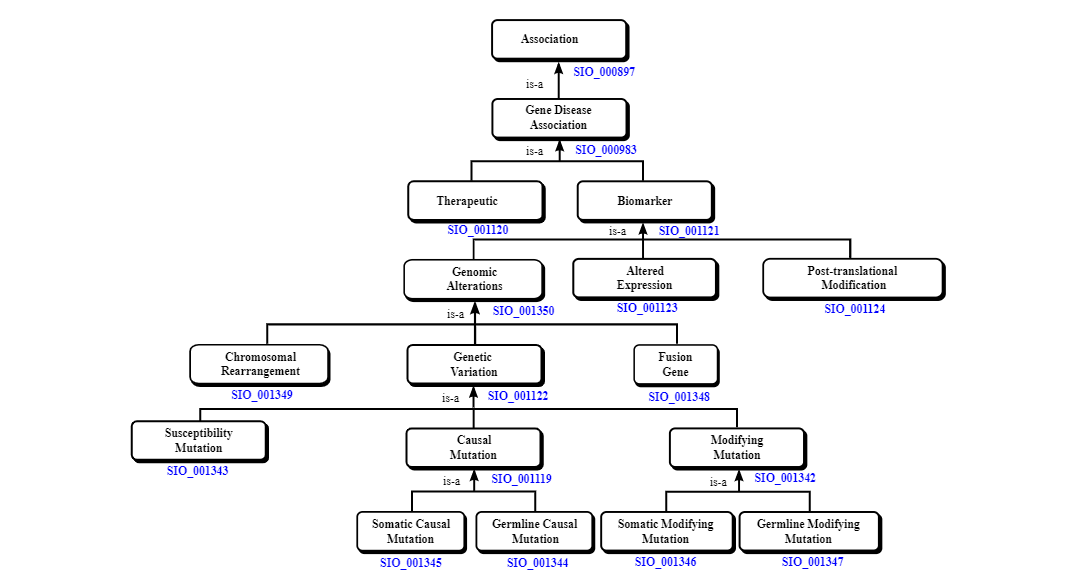

In [23]:
display.Image("Images/hierarchy.PNG")

### The description of each association type in the ontology is:

- Therapeutic: This relationship indicates that the gene/protein has a therapeutic role in the amelioration of the disease.
- Biomarker: This relationship indicates that the gene/protein either plays a role in the etiology of the disease (e.g. participates in the molecular mechanism that leads to disease) or is a biomarker for a disease.
- Genomic Alterations: This relationship indicates that a genomic alteration is linked to the gene associated with the disease phenotype.
- GeneticVariation: This relationship indicates that a sequence variation (a mutation, a SNP) is associated with the disease phenotype, but there is still no evidence to say that the variation causes the disease.
- Causal Mutation: This relationship indicates that there are allelic variants or mutations known to cause the disease.
- Germline Causal Mutation: This relationship indicates that there are germline allelic variants or mutations known to cause the disease, and they may be passed on to offspring.
- Somatic Causal Mutation: This relationship indicates that there are somatic allelic variants or mutations known to cause the disease, but they may not be passed on to offspring.
- Chromosomal Rearrangement: This relationship indicates that a gene is included in a chromosomal rearrangement associated with a particular manifestation of the disease.
- Fusion Gene: This relationship indicates that the fusion between two different genes (between promoter and/or other coding DNA regions) is associated with the disease.
- Susceptibility Mutation: This relationship indicates that a gene mutation in a germ cell that predisposes to the development of a disorder, and that is necessary but not sufficient for the manifestation of the disease.
- Modifying Mutation: This relationship indicates that a gene mutation is known to modify the clinical presentation of the disease.
- Germline Modifying Mutation: This relationship indicates that a germline gene mutation modifies the clinical presentation of the disease, and it may be passed on to offspring.
- Somatic Modifying Mutation: This relationship indicates that a somatic gene mutation modifies the clinical presentation of the disease, but it may not be passed on to offspring.
- AlteredExpression: This relationship indicates that an altered expression of the gene is associated with the disease phenotype.
- Post-translational Modification: This relationship indicates that alterations in the function of the protein by means of post-translational modifications (methylation or phosphorylation of the protein) are associated with the disease phenotype.

## Question Raised:
- What are the distributions of the number of genes per disease for each of these association types?

We needed to better understand the association types in this dataset (their sizes, their variance, their correlation). So, we decided to make one boxplot per association type that is showing the distribution of the number of genes per disease from that type. I would have one plot with the absolute numbers and another with the fraction of genes for a disease from that association type

In [5]:
#Dataset with diseaseNID, geneNID, and associationType:
threeCol = dfOG[['diseaseNID', 'geneNID', 'associationType']]
threeCol

,diseaseNID,geneNID,associationType
0,2107,793,Biomarker
1,431,775,GeneticVariation
2,450,775,GeneticVariation
3,10033,775,GeneticVariation
4,431,7385,Biomarker
...,...,...,...
3261319,30235,1698,ChromosomalRearrangement
3261320,30244,4952,GeneticVariation
3261321,30255,5756,Biomarker
3261322,30255,5756,Biomarker


In [6]:
#Dataset with diseaseNID, associationType, and Counts of Genes per Disease by Association Type:
sumdisease = threeCol.groupby(by = ['diseaseNID', 'associationType']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Association Type')
sumdisease

,diseaseNID,associationType,Counts of Genes per Disease by Association Type
0,2107,Biomarker,88643
1,431,Biomarker,53519
2,2107,AlteredExpression,48737
3,13959,Biomarker,45599
4,397,Biomarker,30313
...,...,...,...
67784,10739,AlteredExpression,1
67785,21891,GermlineCausalMutation,1
67786,10740,Biomarker,1
67787,10741,AlteredExpression,1


<AxesSubplot:xlabel='Counts of Genes per Disease by Association Type', ylabel='associationType'>

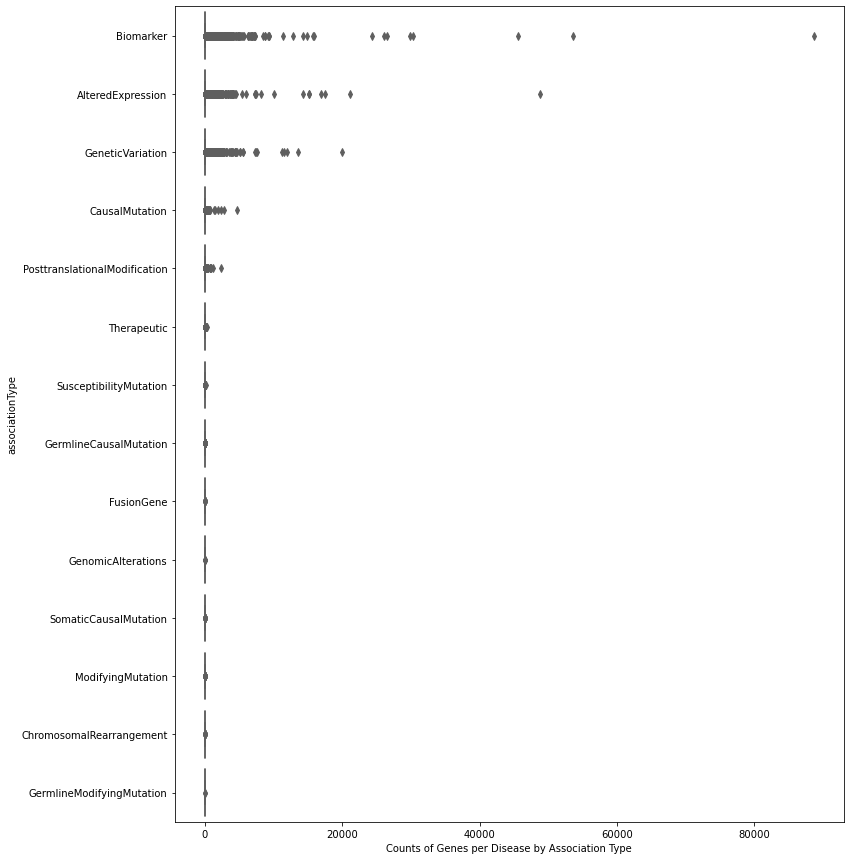

In [9]:
#Boxplot of Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (12,15))
sns.boxplot(y = sumdisease['associationType'], x = sumdisease['Counts of Genes per Disease by Association Type'],
                 data = sumdisease, palette="Set3", orient = 'h')

This plot is showing the absolute numbers, with association type along the y-axis and counts of genes per disease on the x-axis, but it is a bit hard to read due to the large variation in counts, especially with Biomarker, a very general category. Thus, I plotted the log of the count of genes per disease for each association type.

In [10]:
#Dataset with diseaseNID, associationType, and Log of Counts of Genes per Disease by Association Type:
logSumDisease = sumdisease.copy()
logSumDisease['Log of Counts of Genes per Disease by Association Type'] = np.log10(logSumDisease['Counts of Genes per Disease by Association Type'])
logSumDisease

,diseaseNID,associationType,Counts of Genes per Disease by Association Type,Log of Counts of Genes per Disease by Association Type
0,2107,Biomarker,88643,4.947644
1,431,Biomarker,53519,4.728508
2,2107,AlteredExpression,48737,4.687859
3,13959,Biomarker,45599,4.658955
4,397,Biomarker,30313,4.481629
...,...,...,...,...
67784,10739,AlteredExpression,1,0.000000
67785,21891,GermlineCausalMutation,1,0.000000
67786,10740,Biomarker,1,0.000000
67787,10741,AlteredExpression,1,0.000000


<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Association Type', ylabel='associationType'>

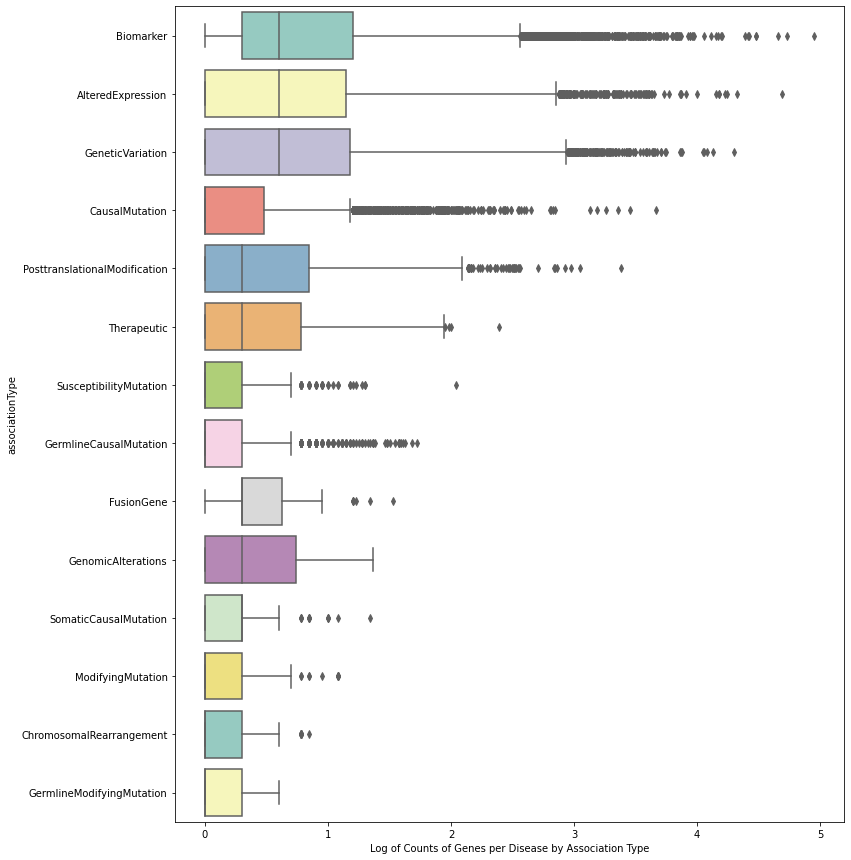

In [11]:
#Boxplot of Log Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (12,15))
sns.boxplot(y = 'associationType', x = 'Log of Counts of Genes per Disease by Association Type',
                 data = logSumDisease, palette="Set3", orient = 'h')

Here is the boxplot for the log of the count of genes per disease for each association type. The axes are the same except the x-axis is now the log of the count. Those association types with a greater median have more genes associated to the specific diseases then some other association types. One can notice that the association types that are more general and more encompassing have the larger medians. By more general, I mean they are higher up in the association type hierarchy. They also have the larger number of outliers, suggesting they have encompassed a larger number of diseases that have unusually large genes associated to certain diseases. We can see that Somatic Causal Mutation, Germline Causal Mutation, Germline Modifying Mutation, Modifying Mutation, and Susceptibility Mutation also have very similar boxplots (minimum, maximum, median, shape of box), which makes a bit of sense when we notice that they are all children or descendants of Genetic Variation. From this, we began to think that it would be better to re-categorize the data so that we have five to six main association types rather than fifteen. Especially when you realize that one of the association types, Somatic Modifying Mutation, did not even have any data to be plotted. 

In [12]:
#Dataset with Fraction of Genes for a Disease per Association Type:
sumdisease2 = threeCol.groupby(by = ['diseaseNID']).size().sort_values(ascending=False).reset_index(name = 'Counts of Diseases')
result = sumdisease.merge(sumdisease2)
result['Ratio'] = result['Counts of Genes per Disease by Association Type']/result['Counts of Diseases']
result

,diseaseNID,associationType,Counts of Genes per Disease by Association Type,Counts of Diseases,Ratio
0,2107,Biomarker,88643,159701,0.555056
1,2107,AlteredExpression,48737,159701,0.305177
2,2107,GeneticVariation,19899,159701,0.124602
3,2107,PosttranslationalModification,2399,159701,0.015022
4,2107,Therapeutic,20,159701,0.000125
...,...,...,...,...,...
67784,10733,GeneticVariation,1,2,0.500000
67785,10733,Biomarker,1,2,0.500000
67786,10735,Biomarker,1,1,1.000000
67787,10736,GeneticVariation,1,1,1.000000


<AxesSubplot:xlabel='Ratio', ylabel='associationType'>

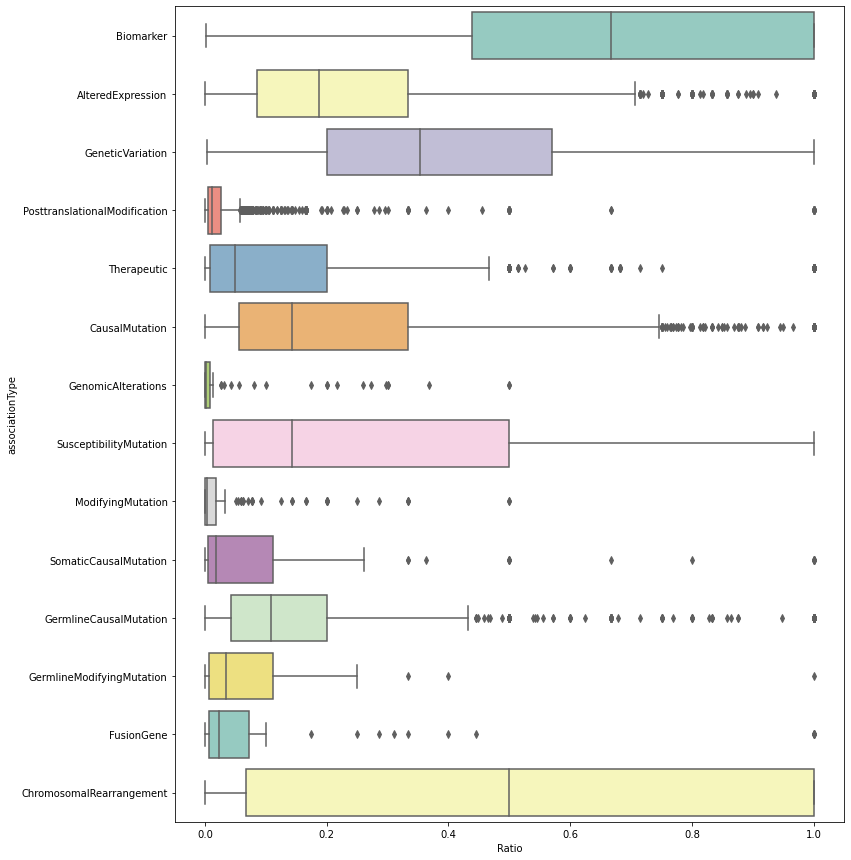

In [13]:
# Boxplot of Fraction of Genes for a Disease per Association Type:
fig, ax = plt.subplots(figsize = (12,15))
sns.boxplot(y = 'associationType', x = 'Ratio',
                 data = result, palette="Set3", orient = 'h')

Then, for each association type, the fraction of genes for a disease divided by all genes for an association type is displayed in a box plot format. One could see for the Biomarker association type, for example, that there is a much larger percentage of genes associated to each disease than compared to some smaller categories. One can also see that almost every association type contains at least one disease that has the entire gene set associated to it. For many of the boxplots, these diseases are considered outliers. The Chromosomal Rearrangement boxplot is also intriguing due to the broadness of its graph. This suggests that the size of the gene sets for diseases contain much variance. Also, for most association types that were lower down, or more specific, on the hierarchy, their median ratios are much closer to 0 than the broader association types. Thus, the more specific association types have smaller percentages of genes associated to each disease. Understanding the reasoning behind this relationship (as well as the relations for the other association types) is important preliminary work to determine the direction to take with this research project.


## QUESTION RAISED:
- Do different experimental methods provide the same view of the underlying biology (lots of gene overlap between association types), or do they present different aspects of it (very separate gene sets)?

I next tried to answer if different experimental methods provide the same view of the underlying biology (lots of gene overlap between association types), or if they present different aspects of it (very separate gene sets). We went about this through comparison of gene sets between association types for every disease in a boxplot and heatmap format.

## Gene Comparison and Exploration:

In [13]:
# Creating Gene Sets for Each Association Type Based on Disease:
a = threeCol.groupby(by = ['diseaseNID', 'associationType'])['geneNID'].apply(lambda x: set(x))
a = a.reset_index()
a

,diseaseNID,associationType,geneNID
0,1,Biomarker,"{1088, 3070}"
1,2,Biomarker,{10721}
2,3,Biomarker,"{522, 525, 7694, 5650, 11283, 5139, 12826, 156..."
3,3,CausalMutation,"{3065, 5458, 1813}"
4,3,GeneticVariation,"{6417, 17182, 4711}"
...,...,...,...
67784,30291,GeneticVariation,{5241}
67785,30292,AlteredExpression,"{3833, 11963, 2493, 270}"
67786,30292,Biomarker,"{18471, 1738, 9805, 270, 46, 19792, 6738, 3829..."
67787,30292,GeneticVariation,"{2403, 1738, 9805, 270, 6738, 3829, 4057}"


In [15]:
# Creating Sets of association Types Based on Disease
a2 = a.groupby(by = ['diseaseNID'])['associationType'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
a2

,diseaseNID,associationType
0,1,{Biomarker}
1,2,{Biomarker}
2,3,"{GeneticVariation, CausalMutation, Biomarker}"
3,4,{Biomarker}
4,5,"{GeneticVariation, AlteredExpression, Biomarker}"
...,...,...
30165,30289,{GeneticVariation}
30166,30290,"{GermlineCausalMutation, GeneticVariation, Cau..."
30167,30291,{GeneticVariation}
30168,30292,"{GeneticVariation, AlteredExpression, Biomarker}"


In [16]:
# Creating the Different Possible Combinations of Association Types for Each Disease:
a2['combinations'] = a2['associationType'].apply(lambda r: list(permutations(r,2)))

In [17]:
# Removing the Diseases that Only Hold One Association Type:
a3 = a2[a2['combinations'].map(lambda d: len(d)) > 0]
a3

,diseaseNID,associationType,combinations
2,3,"{GeneticVariation, CausalMutation, Biomarker}","[(GeneticVariation, CausalMutation), (GeneticV..."
4,5,"{GeneticVariation, AlteredExpression, Biomarker}","[(GeneticVariation, AlteredExpression), (Genet..."
5,6,"{GeneticVariation, CausalMutation, AlteredExpr...","[(GeneticVariation, CausalMutation), (GeneticV..."
6,7,"{CausalMutation, AlteredExpression, GeneticVar...","[(CausalMutation, AlteredExpression), (CausalM..."
7,8,"{GeneticVariation, AlteredExpression, Posttran...","[(GeneticVariation, AlteredExpression), (Genet..."
...,...,...,...
30152,30276,"{GermlineCausalMutation, GeneticVariation, Bio...","[(GermlineCausalMutation, GeneticVariation), (..."
30154,30278,"{GeneticVariation, AlteredExpression, Biomarker}","[(GeneticVariation, AlteredExpression), (Genet..."
30157,30281,"{GeneticVariation, AlteredExpression, Biomarker}","[(GeneticVariation, AlteredExpression), (Genet..."
30166,30290,"{GermlineCausalMutation, GeneticVariation, Cau...","[(GermlineCausalMutation, GeneticVariation), (..."


In [18]:
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseNID) for tup in a3.itertuples() for c in tup.combinations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseNID'})

In [19]:
# Separating the Created Combinations into 2 Columns:
resultGE[['associationType1','associationType2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)

In [20]:
resultGE['geneNID1'] = np.nan
resultGE['geneNID2'] = np.nan

In [21]:
#Finding the gene sets associated to each gene-disease pair association type 
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['associationType'] == row['associationType1'])]
    arowList.append(midrow.iloc[0]['geneNID'])
    
    midrow2 = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['associationType'] == row['associationType2'])]
    arow2List.append(midrow2.iloc[0]['geneNID'])

In [22]:
#Adding the gene sets back into the dataset
resultGE['geneNID1'] = arowList
resultGE['geneNID2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan

In [23]:
# Jaccard Similarity Coefficient/Jaccard Index Function:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [24]:
#Helper function for Jaccard Index
def f(x):
    return jaccard(x['geneNID1'], x['geneNID2']) 

In [25]:
#Obtaining Jaccard Similarity Coefficient Between Gene Sets for each Row
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseNID,associationType1,associationType2,geneNID1,geneNID2,jaccardIndex
0,3,GeneticVariation,CausalMutation,"{6417, 17182, 4711}","{3065, 5458, 1813}",0.000000
1,3,GeneticVariation,Biomarker,"{6417, 17182, 4711}","{522, 525, 7694, 5650, 11283, 5139, 12826, 156...",0.010000
2,3,CausalMutation,GeneticVariation,"{3065, 5458, 1813}","{6417, 17182, 4711}",0.000000
3,3,CausalMutation,Biomarker,"{3065, 5458, 1813}","{522, 525, 7694, 5650, 11283, 5139, 12826, 156...",0.000000
4,3,Biomarker,GeneticVariation,"{522, 525, 7694, 5650, 11283, 5139, 12826, 156...","{6417, 17182, 4711}",0.010000
...,...,...,...,...,...,...
135313,30292,GeneticVariation,Biomarker,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{18471, 1738, 9805, 46, 270, 19792, 6738, 3829...",0.400000
135314,30292,AlteredExpression,GeneticVariation,"{3833, 11963, 2493, 270}","{2403, 1738, 9805, 270, 6738, 3829, 4057}",0.100000
135315,30292,AlteredExpression,Biomarker,"{3833, 11963, 2493, 270}","{18471, 1738, 9805, 46, 270, 19792, 6738, 3829...",0.058824
135316,30292,Biomarker,GeneticVariation,"{18471, 1738, 9805, 46, 270, 19792, 6738, 3829...","{2403, 1738, 9805, 270, 6738, 3829, 4057}",0.400000


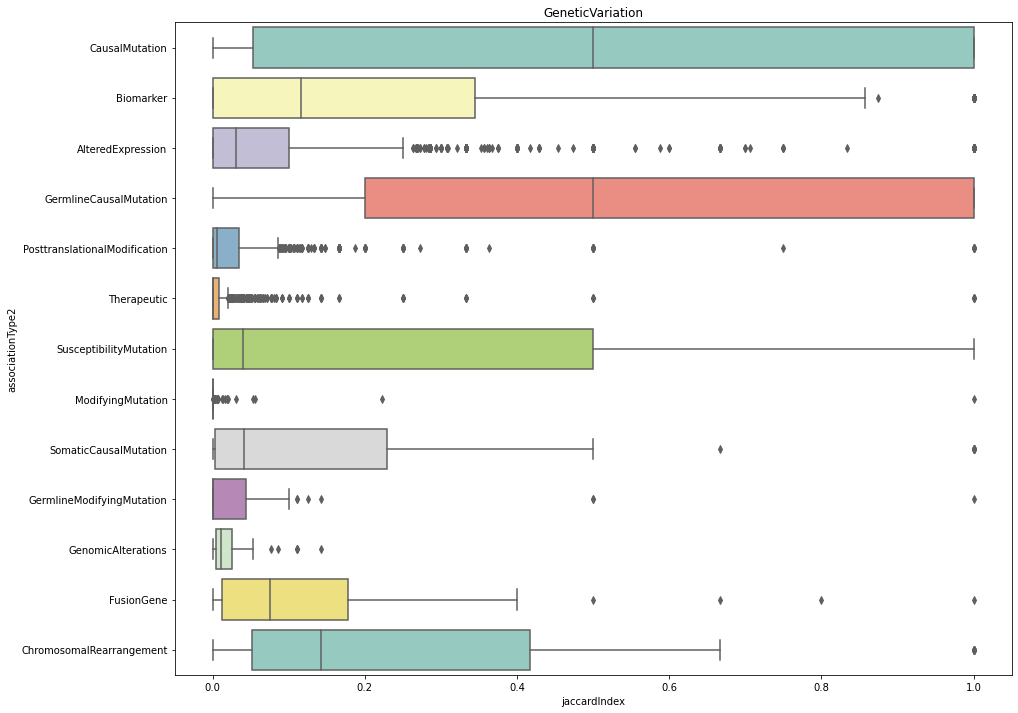

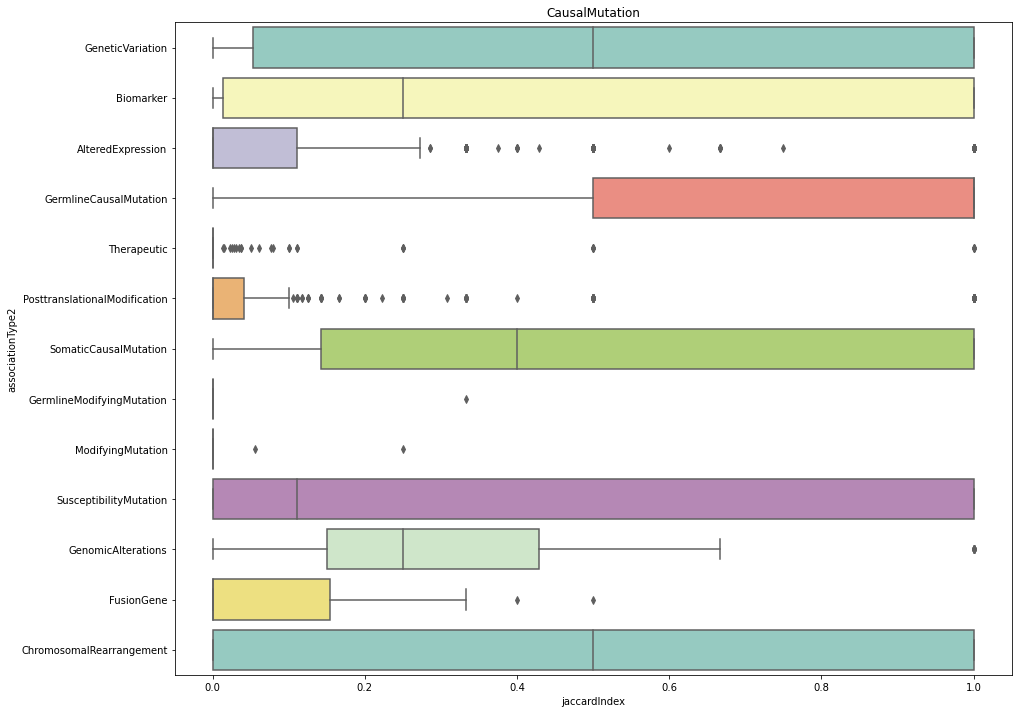

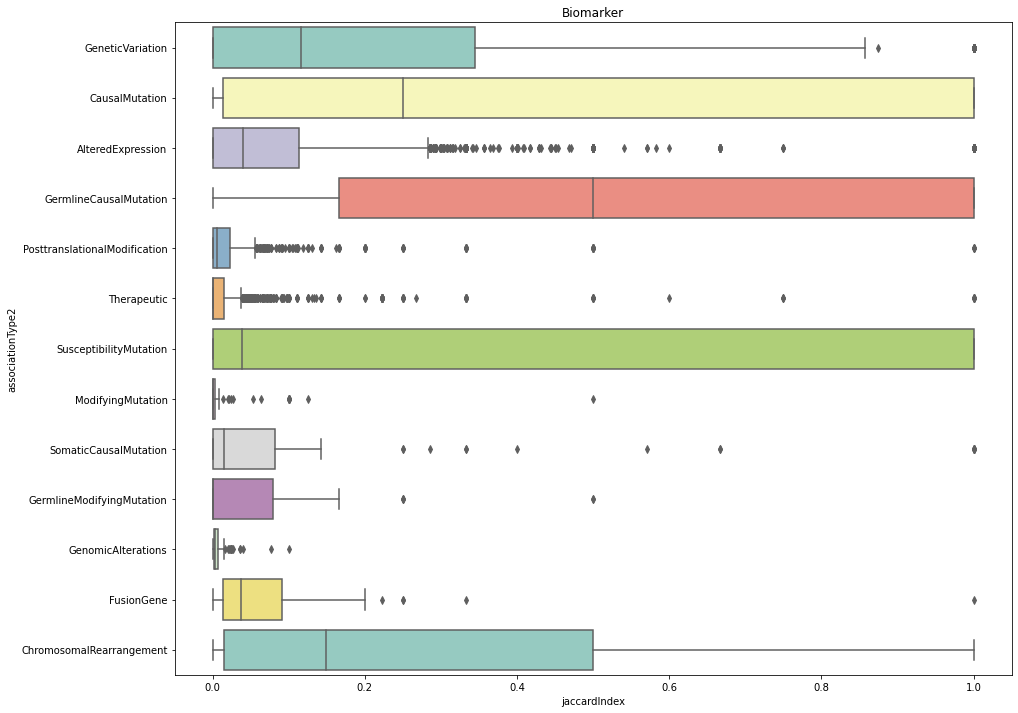

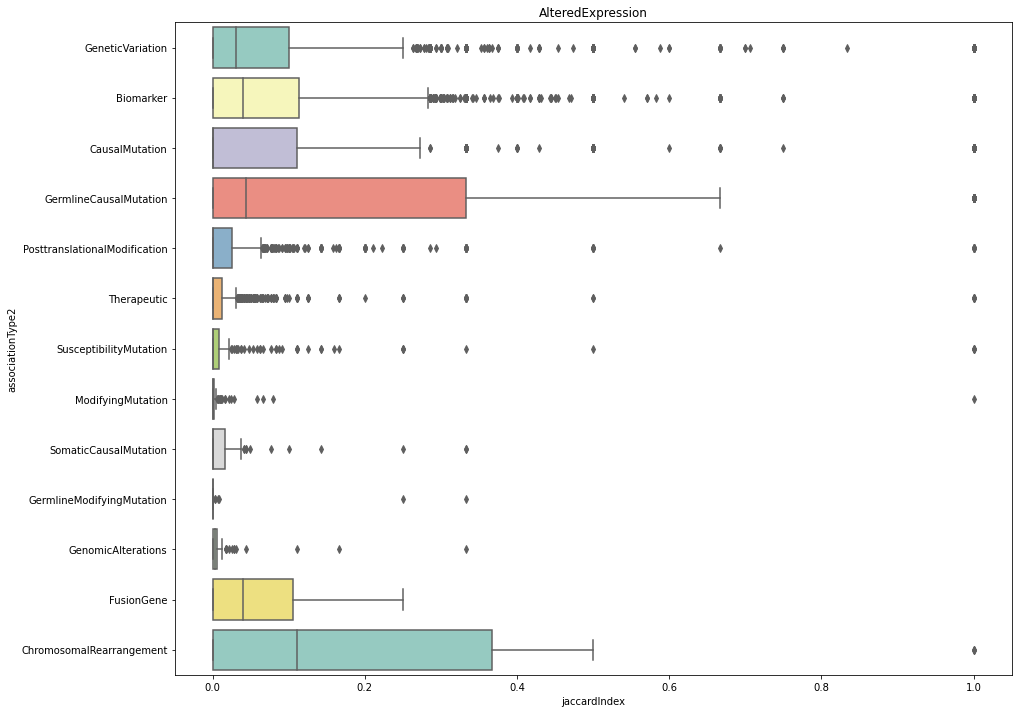

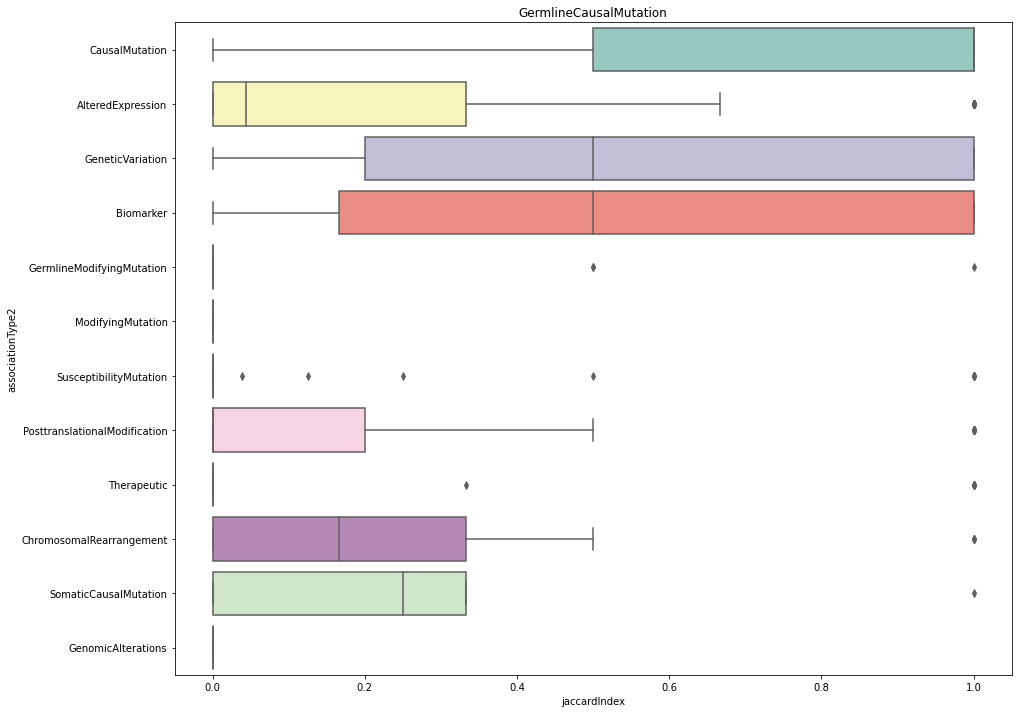

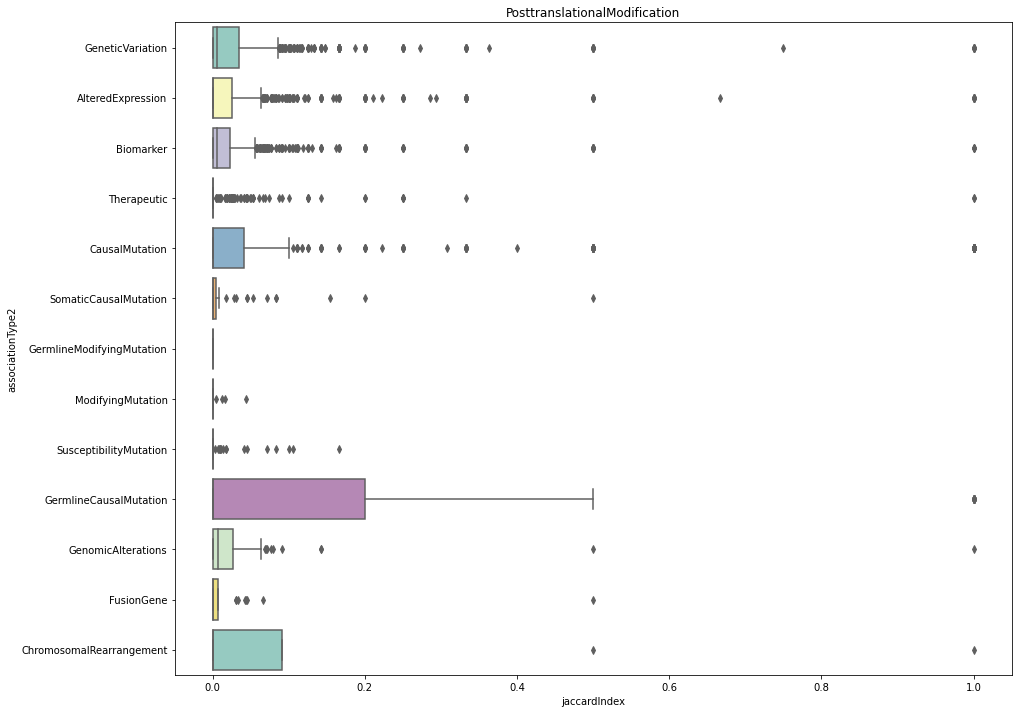

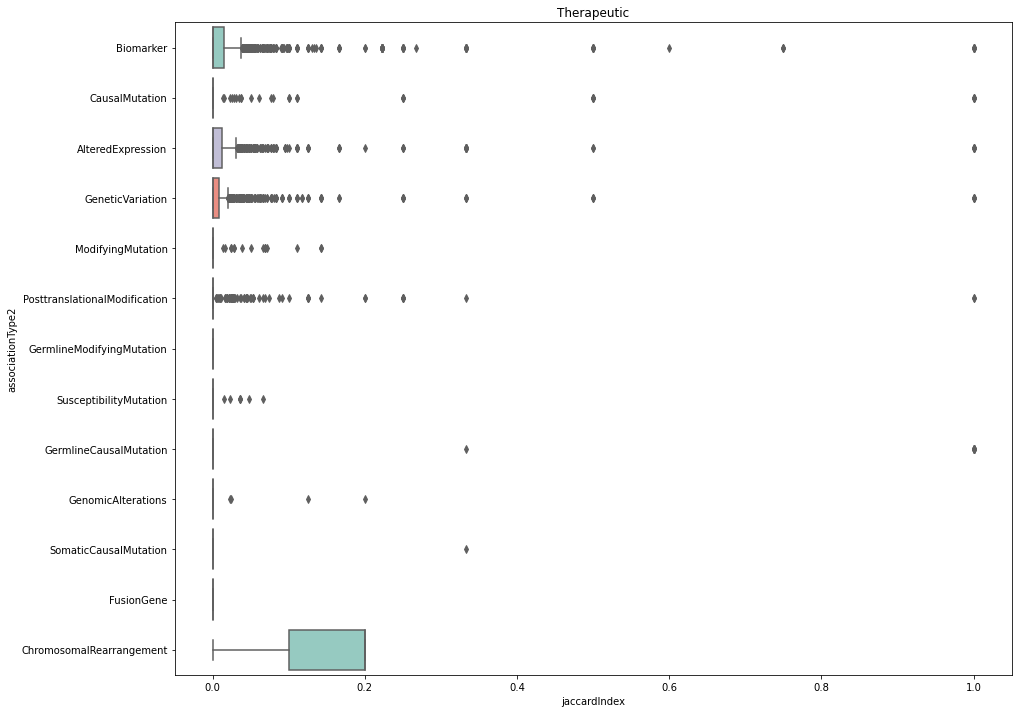

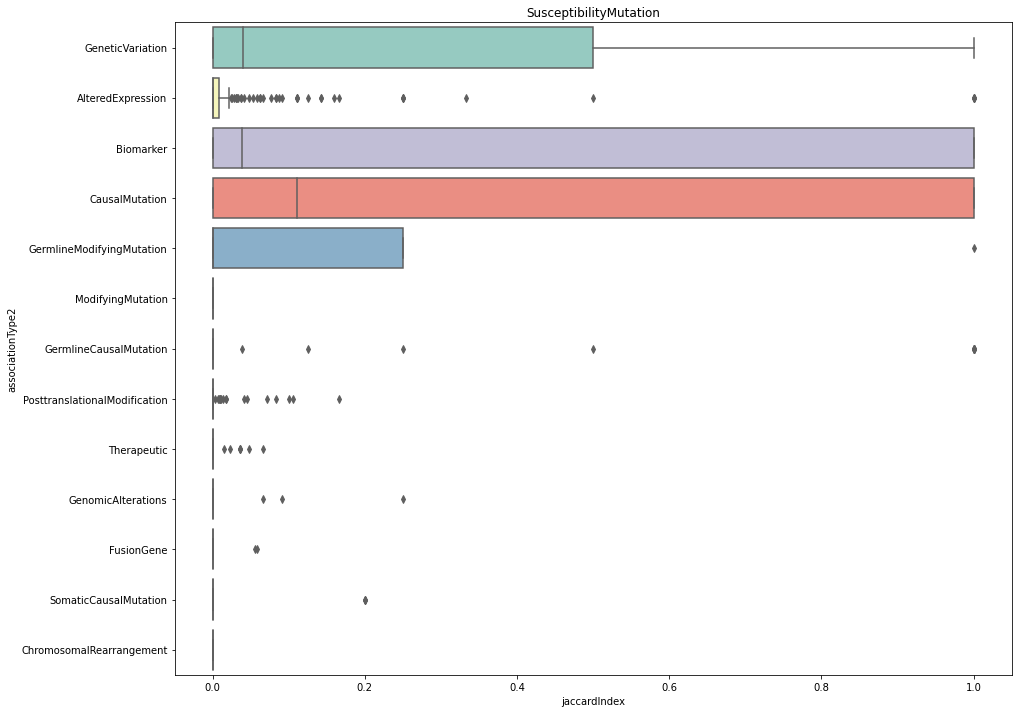

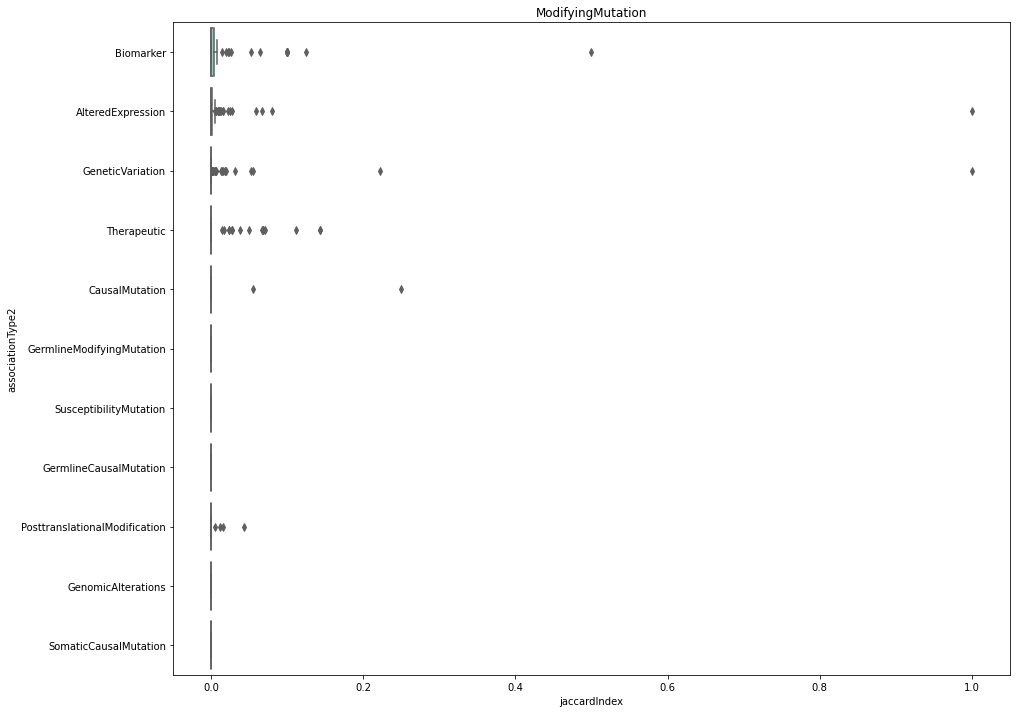

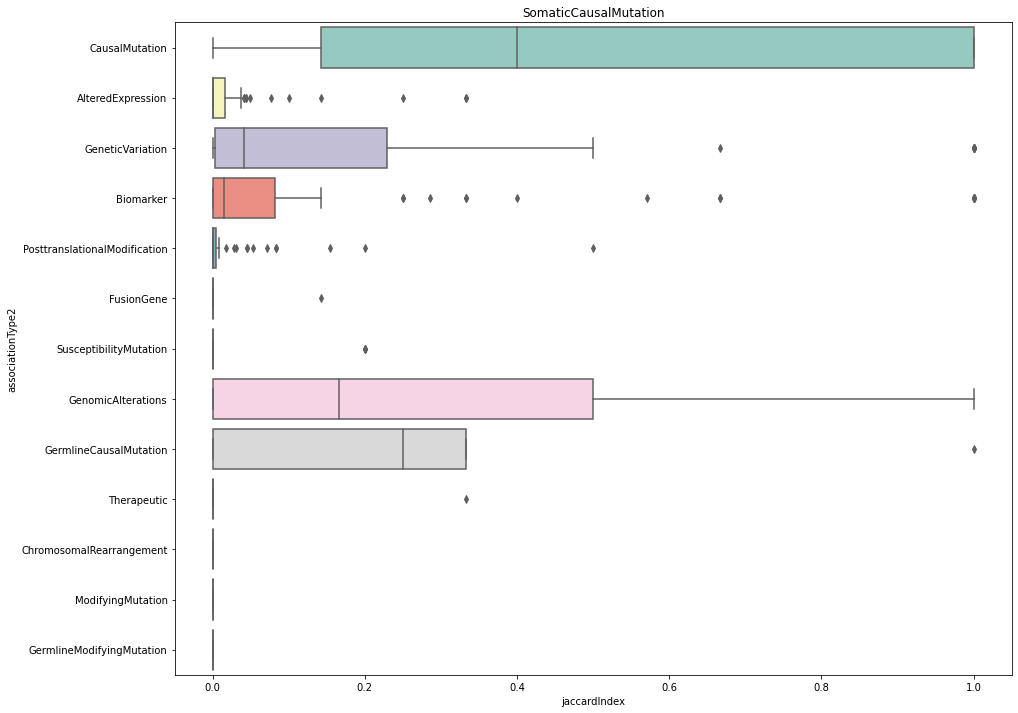

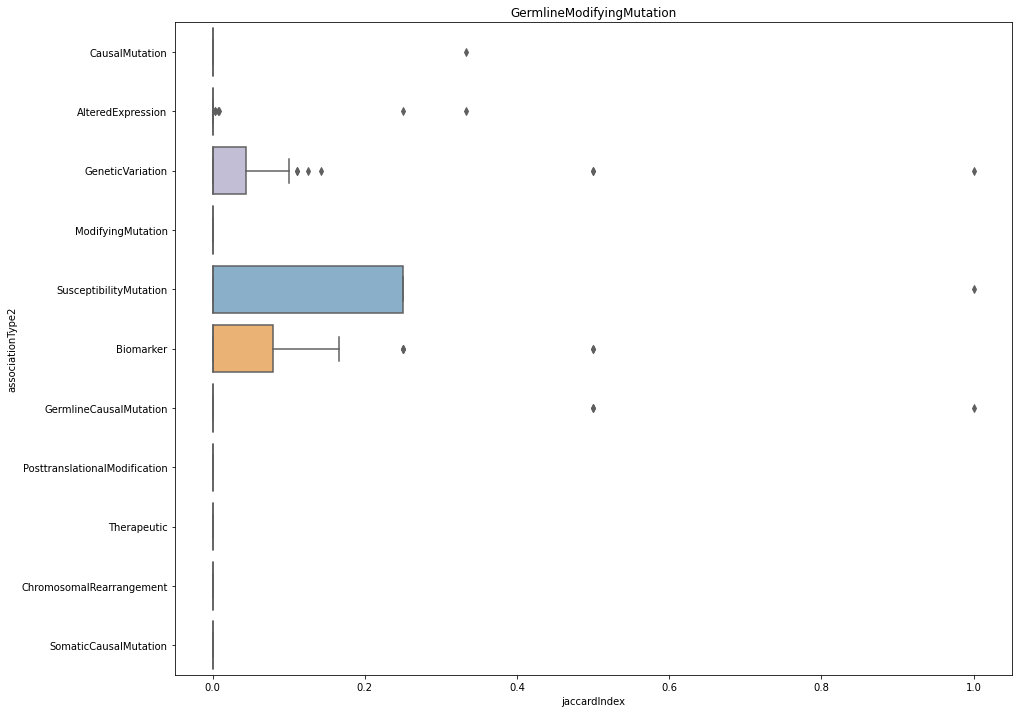

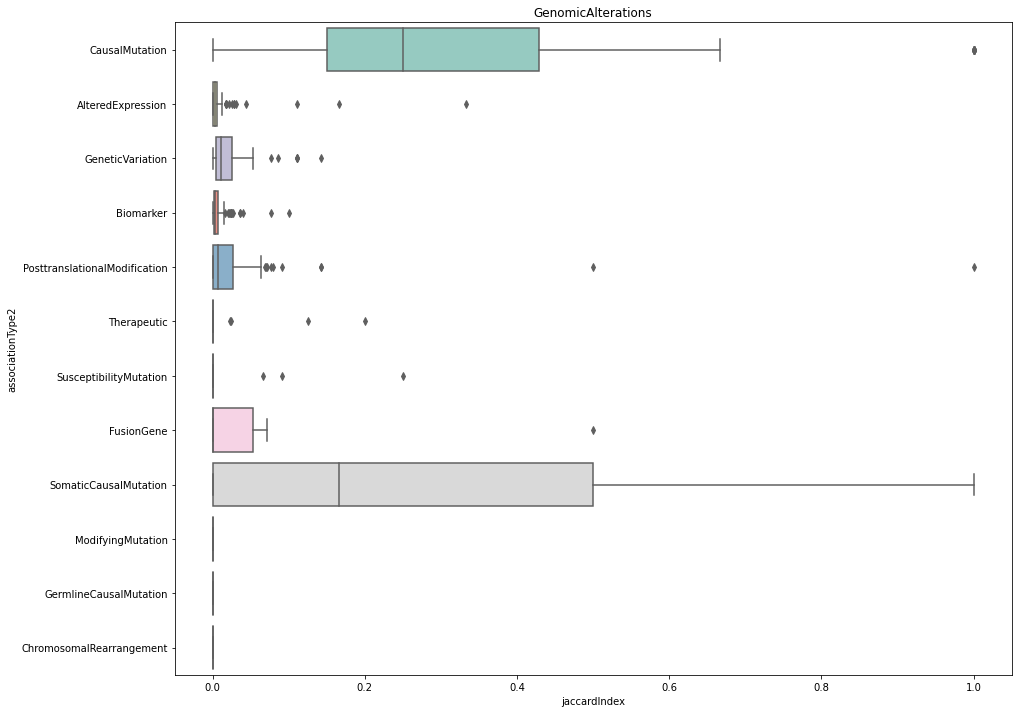

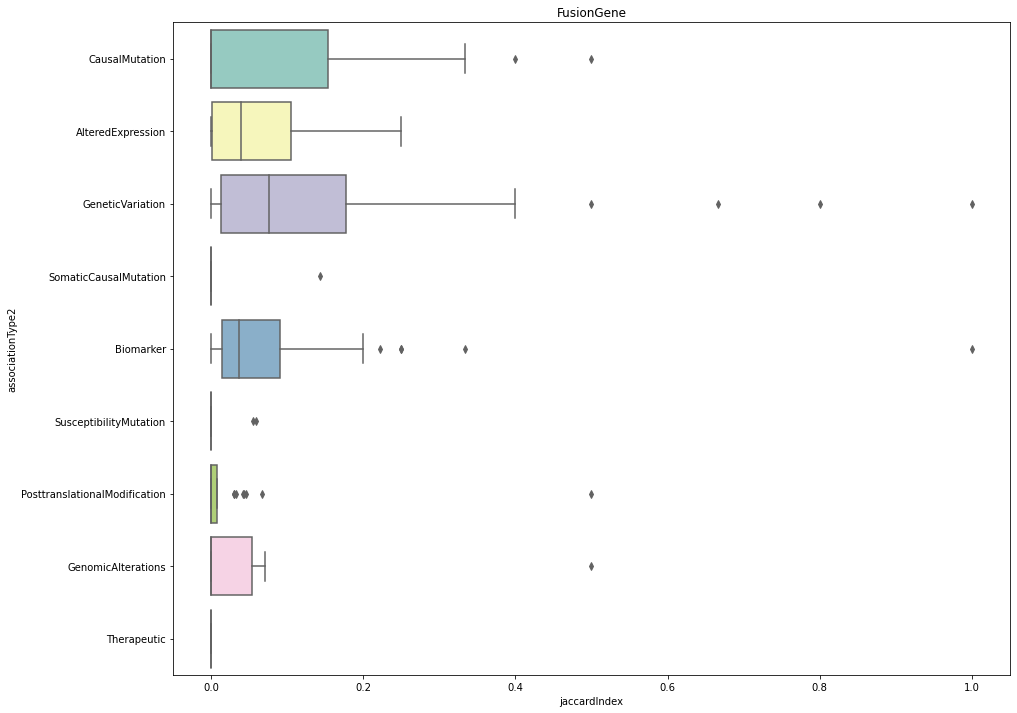

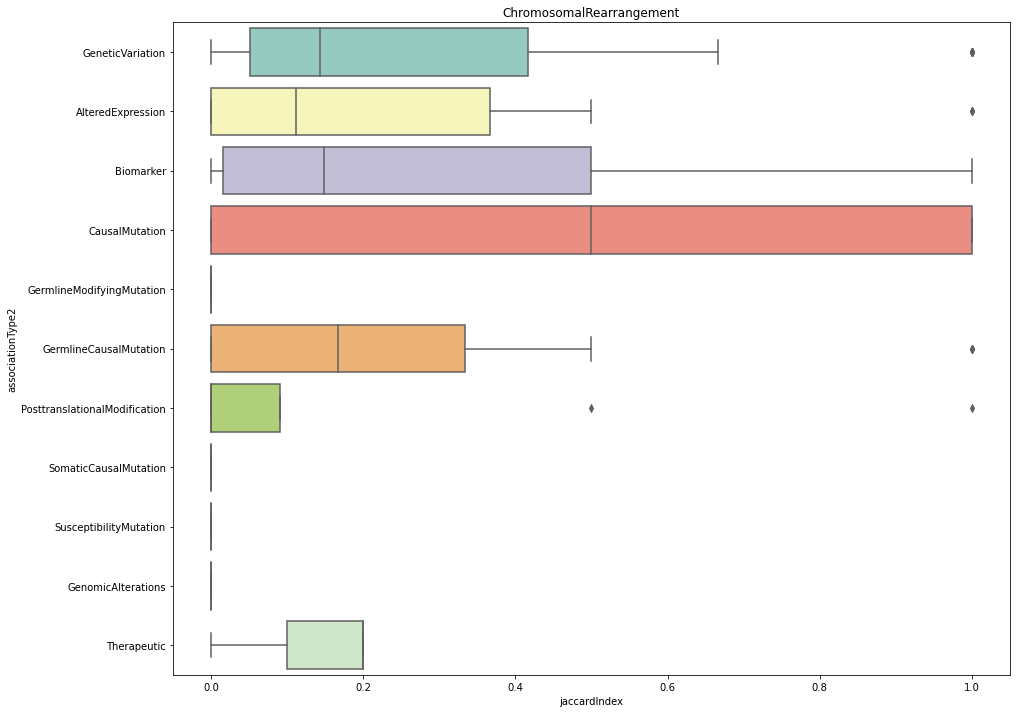

In [26]:
## Boxplots for Gene Exploration:
for i, associationType in enumerate(resultGE.associationType1.unique(), 1): #Iterating through each unique association Type
    data = resultGE[resultGE.associationType1 == associationType] #Filtering by association Type
    fig, ax = plt.subplots(figsize = (15,12))
    sns.boxplot(x = 'jaccardIndex', y = 'associationType2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(associationType)

Fourteen Boxplots were created, one for each association type. For each, the Jaccard Index is along the x-axis and the association types being compared to another (the one stated in the title) on the y-axis. Each Association type from the pair is plotted against its paired association type to demonstrate the correlation between gene sets from the same disease. For example, looking at Causal Mutation, we can see that the correlation between genetic variation and causal mutation as well as biomarker, genetic variation, somatic causal mutation, susceptibility mutation, and chromosomal rearrangement have a lot of variance. Chromosomal rearrangement and Genetic variation also interestingly have a median correlation coefficient of .5, meaning the sets have 50% correlation on average. In contrast, Therapeutic, Posttranslational modification, altered expression, modifying mutation, fusion gene, and germline modifying mutation all have median correlation coefficients of 0, meaning not correlated. This makes sense based on the hierarchy, as all these association types do not have a direct family relationship to causal mutation (parent, grandparent, child, grandchild, etc.), but have relationships such as nephew, aunt, or uncle.

In [27]:
# Reorganizing the Dataset to Obtain the Median Values for Each Association Type Combination:
# This new dataset will have one row for each association type combination, a set of the jaccard Indices for that association type combination, and a median of the values for each of those sets. 
#Those median values are what will be placed in the heatmap
resultGE2 = resultGE.drop(columns = ['diseaseNID', 'geneNID1', 'geneNID2'])
resultGE2 = resultGE2.groupby(by = ['associationType1', 'associationType2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [28]:
#Adding the median of the Jaccard Sets for association type combos to a separate column
jaccardsets = resultGE2['jaccardIndex']
medians = []
for aset in jaccardsets:
    medians.append(statistics.median(aset))
resultGE2['Median'] = medians
resultGE2

,associationType1,associationType2,jaccardIndex,Median
0,AlteredExpression,Biomarker,"[0.1111111111111111, 0.02456140350877193, 0.06...",0.039286
1,AlteredExpression,CausalMutation,"[0.0, 0.07692307692307693, 0.0, 0.111111111111...",0.000000
2,AlteredExpression,ChromosomalRearrangement,"[0.5, 0.2, 0.0, 0.0, 0.11538461538461539, 0.5,...",0.111111
3,AlteredExpression,FusionGene,"[0.018315018315018316, 0.009433962264150943, 0...",0.039855
4,AlteredExpression,GeneticVariation,"[0.0, 0.02702702702702703, 0.08571428571428572...",0.030928
...,...,...,...,...
165,Therapeutic,GermlineModifyingMutation,"[0.0, 0.0]",0.000000
166,Therapeutic,ModifyingMutation,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.06666666...",0.000000
167,Therapeutic,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0687022900763...",0.000000
168,Therapeutic,SomaticCausalMutation,"[0.0, 0.0, 0.0, 0.3333333333333333, 0.0, 0.0, ...",0.000000


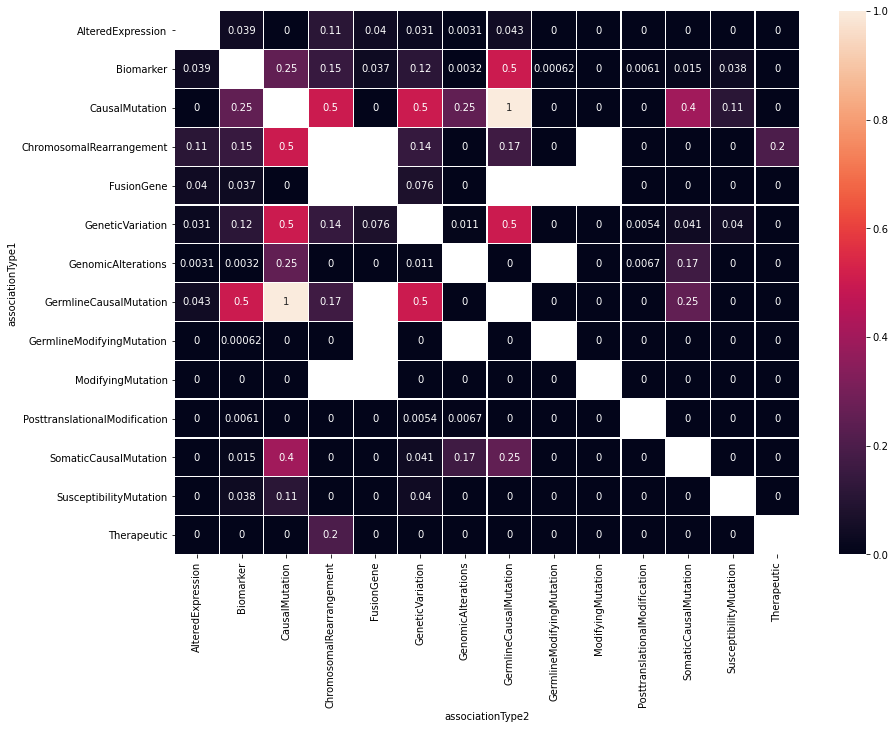

In [29]:
#Heatmap of Median Jaccard Indicies Between Association Type Combinations
resultGE3 = resultGE2.pivot("associationType1", "associationType2", "Median")
fig, ax = plt.subplots(figsize=(14,10))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

Along both axes are all of the association types. We are trying to see which association types have the highest correlation between gene sets. One can see that the diagonal of the heatmap is empty, which makes sense because we purposely did not make association type combinations of the same association type (as the values would all be 1). If I wanted to, I could just change my code to run on permutations with replacements instead of just permutations to fill this diagonal. The heatmap does help to show a few clear highlights/high correlations between association types. CausalMutation/GermlineCausalMutation has a heatmap/median value of 1, suggesting they correlate perfectly. I think it makes sense that they correlate so strongly since Causal Mutation is an ancestor or parent of Germline Causal Mutation. Other high correlations can be seen in the red filled squares between CausalMutation/GeneticVariation, ChromosomalRearrangement/CausalMutation, GeneticVariation/GermlineCausalMutation, and Biomarker/GermlineCausalMutation. All of these are direct family relationships (parent, grandparent, child, grandchild), so I would say it makes sense that their correlations are higher than others. One more thing is that there are empty squares in the permutations heatmap that are not a part of the diagonal. These are for association type pairs that do not have any data to map or compare. For example, Modifying Mutation and Chromosomal Rearrangement, two pretty unrelated association types based on the hierarchy, do not both have data for a certain disease that would allow their gene sets to be compared in this map. Although this heatmap can provide a lot of useful information, we don’t plan to use it in further analysis due to its cumbersomeness to read. Focusing our attention on five or six associations will make more succinct data and plots. 

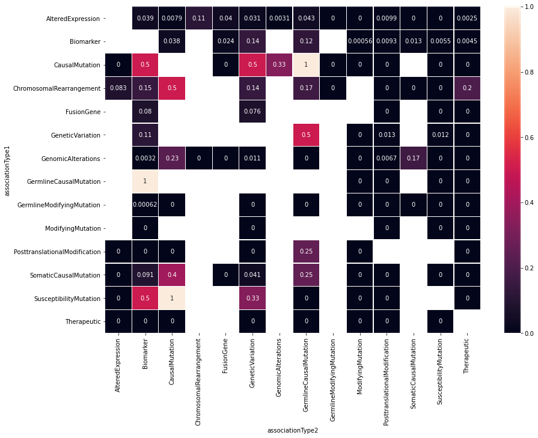

In [24]:
# To see the old heatmap (with combinations rather than permutations), run this cell:
display.Image("Images/combinationHeatmap.png")

## Writing the Data to GMT Files:

In [14]:
#Merging original dataset in GENE SET FORM with diseaseinfo dataset that provides diseaseId (instead of diseaseNID) and the disease name
diseaseinfo = pd.read_csv('DisGeNETFiles/diseaseAttributes.tsv', sep = "\t")
gmtfiledata = a.merge(diseaseinfo)
gmtfiledata

,diseaseNID,associationType,geneNID,diseaseId,diseaseName,type
0,1,Biomarker,"{1088, 3070}",C0000727,"Abdomen, Acute",phenotype
1,2,Biomarker,{10721},C0000729,Abdominal Cramps,phenotype
2,3,Biomarker,"{522, 525, 7694, 5650, 11283, 5139, 12826, 156...",C0000731,Abdomen distended,phenotype
3,3,CausalMutation,"{3065, 5458, 1813}",C0000731,Abdomen distended,phenotype
4,3,GeneticVariation,"{6417, 17182, 4711}",C0000731,Abdomen distended,phenotype
...,...,...,...,...,...,...
67784,30291,GeneticVariation,{5241},C4757951,Desmoplastic infantile astrocytoma and ganglio...,disease
67785,30292,AlteredExpression,"{3833, 11963, 2493, 270}",C4759295,Non-metastatic prostate cancer,disease
67786,30292,Biomarker,"{18471, 1738, 9805, 270, 46, 19792, 6738, 3829...",C4759295,Non-metastatic prostate cancer,disease
67787,30292,GeneticVariation,"{2403, 1738, 9805, 270, 6738, 3829, 4057}",C4759295,Non-metastatic prostate cancer,disease


In [15]:
#Merging original dataset with geneinfo that has geneId (instead of geneNID); then grouping the GENE IDs into sets and merging this data with the above file
#NOTE: WE DO NOT EXPECT THE GENENID TO BE THE SAME AS GENEID, BUT THE SIZE OF THE GENE SETS SHOULD STILL BE THE SAME!
geneinfo = pd.read_csv('DisGeNETFiles/geneAttributes.tsv', sep = "\t")
dfOG = dfOG.merge(geneinfo)
geneID = dfOG.groupby(by = ['diseaseNID', 'associationType'])['geneId'].apply(lambda x: set(x))
geneID = geneID.reset_index()
gmtfiledata = gmtfiledata.merge(geneID)
gmtfiledata

,diseaseNID,associationType,geneNID,diseaseId,diseaseName,type,geneId
0,1,Biomarker,"{1088, 3070}",C0000727,"Abdomen, Acute",phenotype,"{4210, 1468}"
1,2,Biomarker,{10721},C0000729,Abdominal Cramps,phenotype,{54808}
2,3,Biomarker,"{522, 525, 7694, 5650, 11283, 5139, 12826, 156...",C0000731,Abdomen distended,phenotype,"{2050, 7173, 3592, 3594, 4629, 5660, 4638, 668..."
3,3,CausalMutation,"{3065, 5458, 1813}",C0000731,Abdomen distended,phenotype,"{2538, 4204, 7454}"
4,3,GeneticVariation,"{6417, 17182, 4711}",C0000731,Abdomen distended,phenotype,"{6514, 9091, 285175}"
...,...,...,...,...,...,...,...
67784,30291,GeneticVariation,{5241},C4757951,Desmoplastic infantile astrocytoma and ganglio...,disease,{7157}
67785,30292,AlteredExpression,"{3833, 11963, 2493, 270}",C4759295,Non-metastatic prostate cancer,disease,"{5328, 354, 57580, 3429}"
67786,30292,Biomarker,"{18471, 1738, 9805, 270, 46, 19792, 6738, 3829...",C4759295,Non-metastatic prostate cancer,disease,"{354, 1956, 100126309, 4968, 2346, 5324, 2925,..."
67787,30292,GeneticVariation,"{2403, 1738, 9805, 270, 6738, 3829, 4057}",C4759295,Non-metastatic prostate cancer,disease,"{354, 2346, 5324, 29968, 9520, 3283, 5627}"


In [16]:
#Making a new dataset that only has the data we need
gmtdatafinal = gmtfiledata[['associationType','diseaseId', 'diseaseName', 'geneId']]
gmtdatafinal

,associationType,diseaseId,diseaseName,geneId
0,Biomarker,C0000727,"Abdomen, Acute","{4210, 1468}"
1,Biomarker,C0000729,Abdominal Cramps,{54808}
2,Biomarker,C0000731,Abdomen distended,"{2050, 7173, 3592, 3594, 4629, 5660, 4638, 668..."
3,CausalMutation,C0000731,Abdomen distended,"{2538, 4204, 7454}"
4,GeneticVariation,C0000731,Abdomen distended,"{6514, 9091, 285175}"
...,...,...,...,...
67784,GeneticVariation,C4757951,Desmoplastic infantile astrocytoma and ganglio...,{7157}
67785,AlteredExpression,C4759295,Non-metastatic prostate cancer,"{5328, 354, 57580, 3429}"
67786,Biomarker,C4759295,Non-metastatic prostate cancer,"{354, 1956, 100126309, 4968, 2346, 5324, 2925,..."
67787,GeneticVariation,C4759295,Non-metastatic prostate cancer,"{354, 2346, 5324, 29968, 9520, 3283, 5627}"


In [17]:
#I need to turn this dataset (specifically the geneId column) into a string instead of a set for Anna's method to run:
isinstance(gmtdatafinal.iloc[0]['geneId'], set)

True

In [18]:
gmtdatafinal['geneId'] = (gmtdatafinal['geneId']).astype(str)
gmtdatafinal['geneId'] = gmtdatafinal['geneId'].apply(lambda x: set(x[1:-1].split(", ")))
gmtdatafinal

<ipython-input-18-f67a474e5b0b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmtdatafinal['geneId'] = (gmtdatafinal['geneId']).astype(str)
<ipython-input-18-f67a474e5b0b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gmtdatafinal['geneId'] = gmtdatafinal['geneId'].apply(lambda x: set(x[1:-1].split(", ")))


,associationType,diseaseId,diseaseName,geneId
0,Biomarker,C0000727,"Abdomen, Acute","{4210, 1468}"
1,Biomarker,C0000729,Abdominal Cramps,{54808}
2,Biomarker,C0000731,Abdomen distended,"{7068, 3988, 4041, 57560, 65992, 3655, 5449, 8..."
3,CausalMutation,C0000731,Abdomen distended,"{2538, 4204, 7454}"
4,GeneticVariation,C0000731,Abdomen distended,"{285175, 9091, 6514}"
...,...,...,...,...
67784,GeneticVariation,C4757951,Desmoplastic infantile astrocytoma and ganglio...,{7157}
67785,AlteredExpression,C4759295,Non-metastatic prostate cancer,"{354, 57580, 5328, 3429}"
67786,Biomarker,C4759295,Non-metastatic prostate cancer,"{354, 2925, 406988, 4968, 847, 9520, 1956, 55,..."
67787,GeneticVariation,C4759295,Non-metastatic prostate cancer,"{354, 5324, 9520, 3283, 5627, 29968, 2346}"


In [19]:
gmtdatafinal.iloc[0]['geneId']

{'1468', '4210'}

In [20]:
#Creating a dictionary with each association type as the key, and diseaseId, name, and geneId as values in a dataset format. 
dict_of_associations = dict(iter(gmtdatafinal.groupby('associationType')))

In [21]:
#Function provided by Anna to write the data to gmt files
def write_gmt(filename, names, labels):
    with open(filename, "w") as f:
        for term in labels:
            f.write(
                "{}\t{}\t{}\n".format(
                    term, names[term], "\t".join(labels[term])
                )
            )

In [22]:
#Calling the write_gmt function on each association type dictionary
#DO NOT RUN THIS CELL MULTIPLE TIMES!
for associationType in dict_of_associations:
    write_gmt(filename = ("OutputFiles/gmtFiles/" + associationType + ".gmt"), names = (dict_of_associations[associationType].set_index('diseaseId').to_dict()['diseaseName']), 
              labels = (dict_of_associations[associationType].set_index('diseaseId').to_dict()['geneId']))
    

## Determining the Number of Unique Genes for Each Association Type:

In [70]:
unique = threeCol.groupby(by = ['geneNID'])['associationType'].apply(lambda x: set(x))
unique = unique.reset_index()
unique = unique[unique['associationType'].map(lambda d: len(d)) < 2]
unique['associationType'].value_counts()

TypeError: unhashable type: 'set'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'set'


{GeneticVariation}                 2987
{Biomarker}                        1532
{AlteredExpression}                 382
{CausalMutation}                     36
{PosttranslationalModification}      15
{GermlineCausalMutation}              7
{FusionGene}                          1
Name: associationType, dtype: int64

This allows us to determine how many unique genes would be lost in the recategorization we plan to do after propagation. If we had removed Biomarker in totality, like we initially were considering because of its generality, we would be losing analysis for 1532 unique genes. With our categorization choice, we would be losing the unique genes under Genetic Variation, Causal Mutation, Germline Causal Mutation, and Fusion Gene, totaling around 3000 genes of the 30,000+ genes in this database. However, these genes will actually be shown in our dataset in a different way through propagation!

## Digraph/Tree for the Association Type Hierarchy:

To propagate the dataset, we need the association type hierarchy to be available in a usable format, so we use a networkX digraph of the hierarchy.

In [71]:
G = nx.DiGraph()

In [72]:
G.add_node('Therapeutic')
G.add_node('Biomarker')
G.add_node('GenomicAlterations')
G.add_node('AlteredExpression')
G.add_node('PosttranslationalModification')
G.add_node('ChromosomalRearrangement')
G.add_node('GeneticVariation')
G.add_node('FusionGene')
G.add_node('SusceptibilityMutation')
G.add_node('CausalMutation')
G.add_node('ModifyingMutation')
G.add_node('SomaticCausalMutation')
G.add_node('GermlineCausalMutation')
G.add_node('GermlineModifyingMutation')
G.add_node('SomaticModifyingMutation')

In [73]:
G.add_edges_from([('Biomarker', 'GenomicAlterations'), ('Biomarker', 'AlteredExpression'), ('Biomarker', 'PosttranslationalModification'), 
               ('GenomicAlterations','ChromosomalRearrangement'), ('GenomicAlterations','GeneticVariation'), ('GenomicAlterations','FusionGene'), 
               ('GeneticVariation', 'SusceptibilityMutation'), ('GeneticVariation', 'CausalMutation'), ('GeneticVariation', 'ModifyingMutation'), 
               ('CausalMutation', 'SomaticCausalMutation'), ('CausalMutation', 'GermlineCausalMutation'), 
               ('ModifyingMutation', 'SomaticModifyingMutation'), ('ModifyingMutation', 'GermlineModifyingMutation')])

In [74]:
# Getting the Ancestors for a Certain Association Type (Example):
nx.algorithms.dag.ancestors(G, 'SomaticModifyingMutation')

{'Biomarker', 'GeneticVariation', 'GenomicAlterations', 'ModifyingMutation'}

## Propagated Dataset:

In [75]:
# Dataset with Rows Combined with same Gene and Disease
dfcomb = threeCol.groupby(by = ['diseaseNID', 'geneNID'])['associationType'].apply(lambda x: set(x))

In [76]:
dfcomb = dfcomb.reset_index()
dfcomb

,diseaseNID,geneNID,associationType
0,1,1088,{Biomarker}
1,1,3070,{Biomarker}
2,2,10721,{Biomarker}
3,3,54,{Biomarker}
4,3,170,{Biomarker}
...,...,...,...
1135040,30292,11963,{AlteredExpression}
1135041,30292,18471,{Biomarker}
1135042,30292,19792,{Biomarker}
1135043,30293,6353,{Biomarker}


In [77]:
#Making a set of the propagated association types for the listed association type for the disease-gene pair
templist = []
for index, row in dfcomb.iterrows():
    tempSet = set()
    for association in row['associationType']:
        tempSet.update(nx.algorithms.dag.ancestors(G, association))
        tempSet.add(association)
    templist.append(tempSet)
dfcomb['propagatedAssociationTypes'] = templist
dfcomb

,diseaseNID,geneNID,associationType,propagatedAssociationTypes
0,1,1088,{Biomarker},{Biomarker}
1,1,3070,{Biomarker},{Biomarker}
2,2,10721,{Biomarker},{Biomarker}
3,3,54,{Biomarker},{Biomarker}
4,3,170,{Biomarker},{Biomarker}
...,...,...,...,...
1135040,30292,11963,{AlteredExpression},"{AlteredExpression, Biomarker}"
1135041,30292,18471,{Biomarker},{Biomarker}
1135042,30292,19792,{Biomarker},{Biomarker}
1135043,30293,6353,{Biomarker},{Biomarker}


In [78]:
#Making a dataset with all potentially desired information
geneinfo = geneinfo.drop(columns = ['pLI', 'DSI', 'DPI'])
result1 = dfcomb.merge(diseaseinfo)
combined = result1.merge(geneinfo)
combined

,diseaseNID,geneNID,associationType,propagatedAssociationTypes,diseaseId,diseaseName,type,geneId,geneName,geneDescription
0,1,1088,{Biomarker},{Biomarker},C0000727,"Abdomen, Acute",phenotype,1468,SLC25A10,solute carrier family 25 member 10
1,448,1088,{Biomarker},{Biomarker},C0007097,Carcinoma,group,1468,SLC25A10,solute carrier family 25 member 10
2,589,1088,{Biomarker},{Biomarker},C0008626,Congenital chromosomal disease,group,1468,SLC25A10,solute carrier family 25 member 10
3,827,1088,{Biomarker},{Biomarker},C0012739,Disseminated Intravascular Coagulation,disease,1468,SLC25A10,solute carrier family 25 member 10
4,1102,1088,{Biomarker},{Biomarker},C0016169,pathologic fistula,phenotype,1468,SLC25A10,solute carrier family 25 member 10
...,...,...,...,...,...,...,...,...,...,...
1135040,29802,18837,{AlteredExpression},"{AlteredExpression, Biomarker}",C4721806,"Carcinoma, Basal Cell",disease,503837,DEFB108C,defensin beta 108C
1135041,29932,21333,{Biomarker},{Biomarker},C4728046,Diabetic wound,disease,100847065,MIR5591,microRNA 5591
1135042,30104,25482,{CausalMutation},"{GeneticVariation, CausalMutation, GenomicAlte...",C4748403,SPERMATOGENIC FAILURE 34,disease,107985781,FSIP2-AS1,FSIP2 antisense RNA 1
1135043,30147,21709,{CausalMutation},"{GeneticVariation, CausalMutation, GenomicAlte...",C4748760,"MITOCHONDRIAL COMPLEX I DEFICIENCY, NUCLEAR TY...",disease,101927275,NDUFV2-AS1,NDUFV2 antisense RNA 1


# Recategorized Dataset (Unique Biomarker):

In [79]:
prop = combined.drop(columns = ['diseaseId', 'diseaseName', 'type', 'geneId', 'geneName', 'geneDescription'])
prop

,diseaseNID,geneNID,associationType,propagatedAssociationTypes
0,1,1088,{Biomarker},{Biomarker}
1,448,1088,{Biomarker},{Biomarker}
2,589,1088,{Biomarker},{Biomarker}
3,827,1088,{Biomarker},{Biomarker}
4,1102,1088,{Biomarker},{Biomarker}
...,...,...,...,...
1135040,29802,18837,{AlteredExpression},"{AlteredExpression, Biomarker}"
1135041,29932,21333,{Biomarker},{Biomarker}
1135042,30104,25482,{CausalMutation},"{GeneticVariation, CausalMutation, GenomicAlte..."
1135043,30147,21709,{CausalMutation},"{GeneticVariation, CausalMutation, GenomicAlte..."


In [80]:
#Separating out all rows that have Biomarker as their ONLY association type
bm = prop[prop['associationType'].map(lambda d: d) == {'Biomarker'}]
bm['propagatedAssociationTypes'] = bm['propagatedAssociationTypes'].apply(lambda x: ("".join(x)))
bm = bm.rename(columns={'associationType': 'ogAssociationTypes', 'propagatedAssociationTypes': 'propagatedAssociationType'})
bm

<ipython-input-80-1e57f45125ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bm['propagatedAssociationTypes'] = bm['propagatedAssociationTypes'].apply(lambda x: ("".join(x)))


,diseaseNID,geneNID,ogAssociationTypes,propagatedAssociationType
0,1,1088,{Biomarker},Biomarker
1,448,1088,{Biomarker},Biomarker
2,589,1088,{Biomarker},Biomarker
3,827,1088,{Biomarker},Biomarker
4,1102,1088,{Biomarker},Biomarker
...,...,...,...,...
1135029,29239,20075,{Biomarker},Biomarker
1135030,29280,20163,{Biomarker},Biomarker
1135032,29341,20169,{Biomarker},Biomarker
1135035,29763,9527,{Biomarker},Biomarker


In [81]:
#Separating out all rows that do not have Biomarker as their ONLY association type
nonbm = prop[prop['associationType'].map(lambda d: d) != {'Biomarker'}]
#Splitting the association types in the propagated association type set each into their own line
result = pd.DataFrame([(c, tup.diseaseNID, tup.geneNID, tup.associationType) for tup in nonbm.itertuples() for c in tup.propagatedAssociationTypes])
result = result.rename(columns= {0: 'propagatedAssociationType', 1: 'diseaseNID', 2: 'geneNID', 3: 'ogAssociationTypes'})
#Now we only keep rows that have our other four chosen association types
result2 = result[result['propagatedAssociationType'].map(lambda d: d == 'AlteredExpression' or d =='GenomicAlterations' or d == 'Therapeutic' or d == 'PosttranslationalModification') ]
result2

,propagatedAssociationType,diseaseNID,geneNID,ogAssociationTypes
0,AlteredExpression,1317,1088,{AlteredExpression}
2,AlteredExpression,1338,1088,{AlteredExpression}
4,AlteredExpression,1741,1088,{AlteredExpression}
6,PosttranslationalModification,2107,1088,{PosttranslationalModification}
8,AlteredExpression,2592,1088,{AlteredExpression}
...,...,...,...,...
1553751,AlteredExpression,29802,18834,{AlteredExpression}
1553753,AlteredExpression,29802,18837,{AlteredExpression}
1553757,GenomicAlterations,30104,25482,{CausalMutation}
1553761,GenomicAlterations,30147,21709,{CausalMutation}


In [82]:
#Appending the Unique Biomarker Data and the Four Propagated Association Type Data together
result3 = result2.append(bm)
result3 = result3[["diseaseNID", "geneNID", "propagatedAssociationType", "ogAssociationTypes"]]
result3

,diseaseNID,geneNID,propagatedAssociationType,ogAssociationTypes
0,1317,1088,AlteredExpression,{AlteredExpression}
2,1338,1088,AlteredExpression,{AlteredExpression}
4,1741,1088,AlteredExpression,{AlteredExpression}
6,2107,1088,PosttranslationalModification,{PosttranslationalModification}
8,2592,1088,AlteredExpression,{AlteredExpression}
...,...,...,...,...
1135029,29239,20075,Biomarker,{Biomarker}
1135030,29280,20163,Biomarker,{Biomarker}
1135032,29341,20169,Biomarker,{Biomarker}
1135035,29763,9527,Biomarker,{Biomarker}


In [83]:
result3.to_csv('OutputFiles/relabeledDataset.csv', index = False)

In [84]:
#Getting rid of ogAssociationTypes
threeCol = result3.drop(columns = 'ogAssociationTypes')
threeCol

,diseaseNID,geneNID,propagatedAssociationType
0,1317,1088,AlteredExpression
2,1338,1088,AlteredExpression
4,1741,1088,AlteredExpression
6,2107,1088,PosttranslationalModification
8,2592,1088,AlteredExpression
...,...,...,...
1135029,29239,20075,Biomarker
1135030,29280,20163,Biomarker
1135032,29341,20169,Biomarker
1135035,29763,9527,Biomarker


In [85]:
# Dataset with diseaseNID, associationType, and Counts of Genes per Disease by Association Type (Log and non-log):
logSumDisease = threeCol.groupby(by = ['diseaseNID', 'propagatedAssociationType']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Association Type')
logSumDisease['Log of Counts of Genes per Disease by Association Type'] = np.log10(logSumDisease['Counts of Genes per Disease by Association Type'])
logSumDisease

,diseaseNID,propagatedAssociationType,Counts of Genes per Disease by Association Type,Log of Counts of Genes per Disease by Association Type
0,2107,AlteredExpression,6792,3.831998
1,431,AlteredExpression,4855,3.686189
2,13959,AlteredExpression,4526,3.655715
3,13536,AlteredExpression,4103,3.613102
4,2104,AlteredExpression,3861,3.586700
...,...,...,...,...
54200,20457,GenomicAlterations,1,0.000000
54201,9067,GenomicAlterations,1,0.000000
54202,9067,PosttranslationalModification,1,0.000000
54203,20454,GenomicAlterations,1,0.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Association Type', ylabel='propagatedAssociationType'>

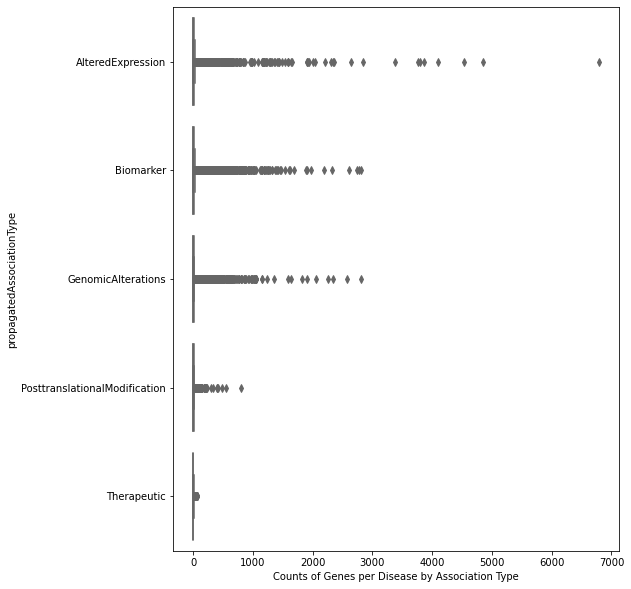

In [86]:
#Boxplot of Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Counts of Genes per Disease by Association Type',
                 data = logSumDisease, palette="Set3", orient = 'h')

This Boxplot of Counts of Genes per Disease for each Association Type, with the association type on the y-axis and the count of genes per disease on the x-axis, helps to demonstrate the large variation in gene set sizes, especially for Altered Expression, Biomarker, and Genomic Alterations.

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Association Type', ylabel='propagatedAssociationType'>

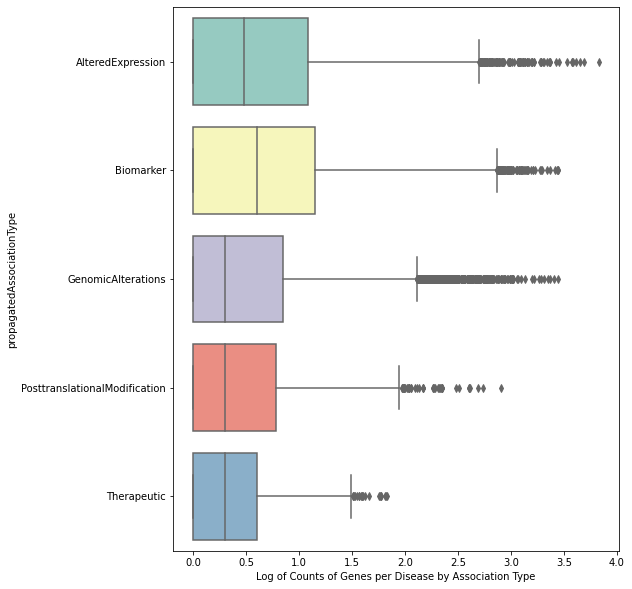

In [87]:
#Boxplot of Log of Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Log of Counts of Genes per Disease by Association Type',
                 data = logSumDisease, palette="Set3", orient = 'h')

This Boxplot of Log of Counts of Genes per Disease for each Association Type helps us to better see the data, and that the median log size of gene sets for a disease are around 0 to 0.5 for all association types. Even though all association types have diseases with abnormally large gene sets (outliers), generally they are all pretty small. 


In [88]:
# Dataset with Fraction of Genes for a Disease per Association Type:
logSumDisease2 = threeCol.groupby(by = ['diseaseNID']).size().sort_values(ascending=False).reset_index(name = 'Counts of Diseases')
result = logSumDisease.merge(logSumDisease2)
result['Ratio'] = result['Counts of Genes per Disease by Association Type']/result['Counts of Diseases']
result

,diseaseNID,propagatedAssociationType,Counts of Genes per Disease by Association Type,Log of Counts of Genes per Disease by Association Type,Counts of Diseases,Ratio
0,2107,AlteredExpression,6792,3.831998,13020,0.521659
1,2107,GenomicAlterations,2802,3.447468,13020,0.215207
2,2107,Biomarker,2609,3.416474,13020,0.200384
3,2107,PosttranslationalModification,802,2.904174,13020,0.061598
4,2107,Therapeutic,15,1.176091,13020,0.001152
...,...,...,...,...,...,...
54200,9065,Therapeutic,1,0.000000,1,1.000000
54201,9066,Therapeutic,1,0.000000,1,1.000000
54202,20457,GenomicAlterations,1,0.000000,1,1.000000
54203,20454,GenomicAlterations,1,0.000000,1,1.000000


<AxesSubplot:xlabel='Ratio', ylabel='propagatedAssociationType'>

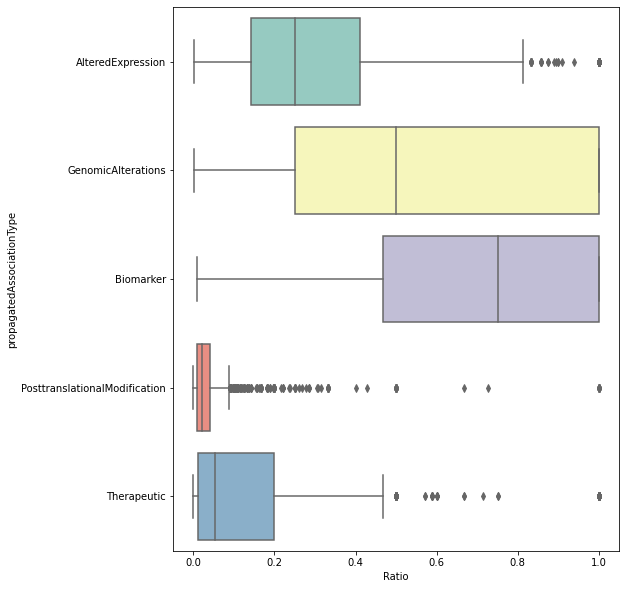

In [89]:
#Boxplot of Fraction of Genes for a Disease per Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Ratio',
                 data = result, palette="Set3", orient = 'h')

This Boxplot of Fraction of Genes for a Disease per Association Type demonstrates that Biomarker has a much larger percentage of genes associated to each disease for all genes associated to Biomarker than compared to the other four. In contrast, Posttranslational modification has diseases that have a very small fraction of the total genes listed for that association type. 


## Gene Comparison and Exploration:

In [90]:
# Creating Gene Sets for Each Association Type Based on Disease:
a = threeCol.groupby(by = ['diseaseNID', 'propagatedAssociationType'])['geneNID'].apply(lambda x: set(x))
a = a.reset_index()
# Creating Sets of association Types Based on Disease
a2 = a.groupby(by = ['diseaseNID'])['propagatedAssociationType'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
# Creating the Different Possible Combinations of Association Types for Each Disease:
from itertools import product
a2['permutations'] = a2['propagatedAssociationType'].apply(lambda r: list(permutations(r,2)))

In [91]:
# Removing the Diseases that Only Hold One Association Type:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseNID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseNID'})
# Separating the Created Combinations into 2 Columns:
resultGE[['associationType1','associationType2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)
resultGE

,Combos,diseaseNID,associationType1,associationType2
0,"(GenomicAlterations, Biomarker)",3,GenomicAlterations,Biomarker
1,"(Biomarker, GenomicAlterations)",3,Biomarker,GenomicAlterations
2,"(AlteredExpression, GenomicAlterations)",5,AlteredExpression,GenomicAlterations
3,"(AlteredExpression, Biomarker)",5,AlteredExpression,Biomarker
4,"(GenomicAlterations, AlteredExpression)",5,GenomicAlterations,AlteredExpression
...,...,...,...,...
73623,"(AlteredExpression, Biomarker)",30292,AlteredExpression,Biomarker
73624,"(GenomicAlterations, AlteredExpression)",30292,GenomicAlterations,AlteredExpression
73625,"(GenomicAlterations, Biomarker)",30292,GenomicAlterations,Biomarker
73626,"(Biomarker, AlteredExpression)",30292,Biomarker,AlteredExpression


In [92]:
#Finding the associated gene sets
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propagatedAssociationType'] == row['associationType1'])]
    arowList.append(midrow.iloc[0]['geneNID'])
    
    midrow2 = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propagatedAssociationType'] == row['associationType2'])]
    arow2List.append(midrow2.iloc[0]['geneNID'])

In [93]:
#Adding the gene sets into the dataset
resultGE['geneNID1'] = arowList
resultGE['geneNID2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan
#Adding in the jaccard similarity coefficient
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseNID,associationType1,associationType2,geneNID1,geneNID2,jaccardIndex
0,3,GenomicAlterations,Biomarker,"{4711, 6417, 5458, 1813, 3065, 17182}","{522, 525, 7694, 5650, 5139, 11283, 12826, 156...",0.0
1,3,Biomarker,GenomicAlterations,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156...","{4711, 6417, 5458, 1813, 3065, 17182}",0.0
2,5,AlteredExpression,GenomicAlterations,"{3288, 1924}","{5304, 5241, 8699, 2126}",0.0
3,5,AlteredExpression,Biomarker,"{3288, 1924}","{129, 4577, 3559, 11754, 1489, 3799, 1567}",0.0
4,5,GenomicAlterations,AlteredExpression,"{5304, 5241, 8699, 2126}","{3288, 1924}",0.0
...,...,...,...,...,...,...
73623,30292,AlteredExpression,Biomarker,"{3833, 11963, 2493, 270}","{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}",0.0
73624,30292,GenomicAlterations,AlteredExpression,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{3833, 11963, 2493, 270}",0.1
73625,30292,GenomicAlterations,Biomarker,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}",0.0
73626,30292,Biomarker,AlteredExpression,"{18471, 46, 19792, 632, 1115, 1436, 2111, 3551}","{3833, 11963, 2493, 270}",0.0


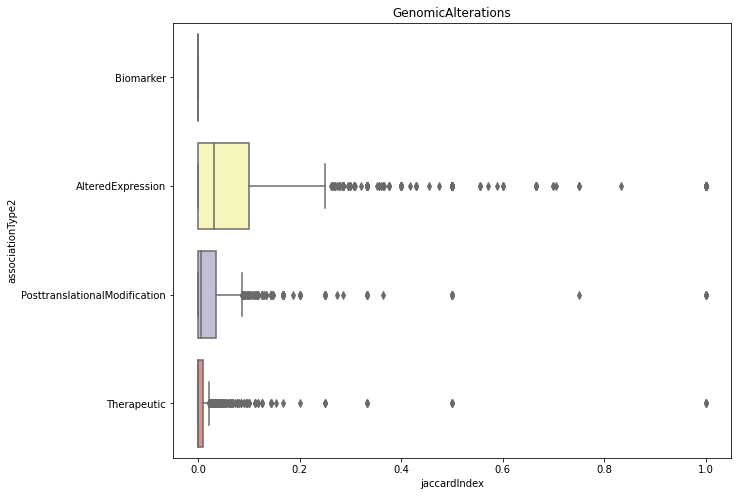

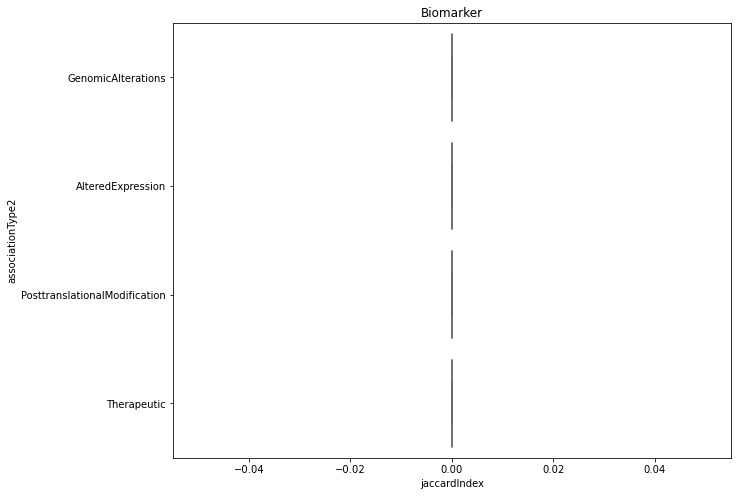

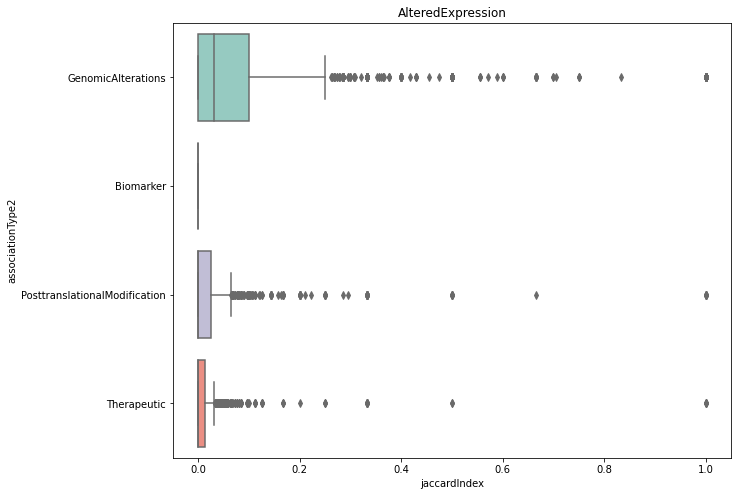

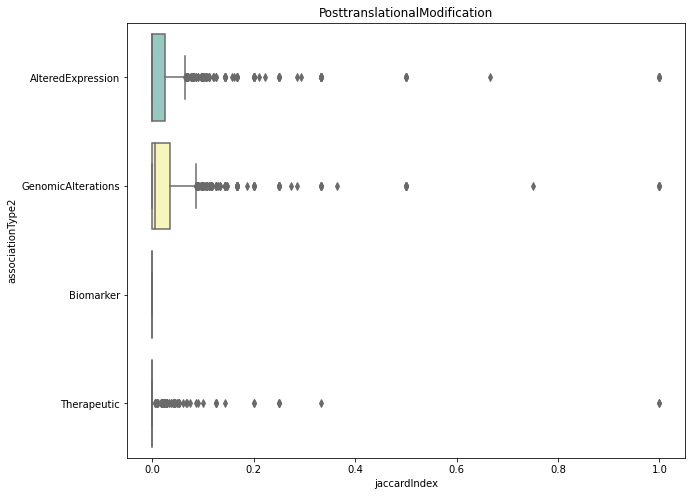

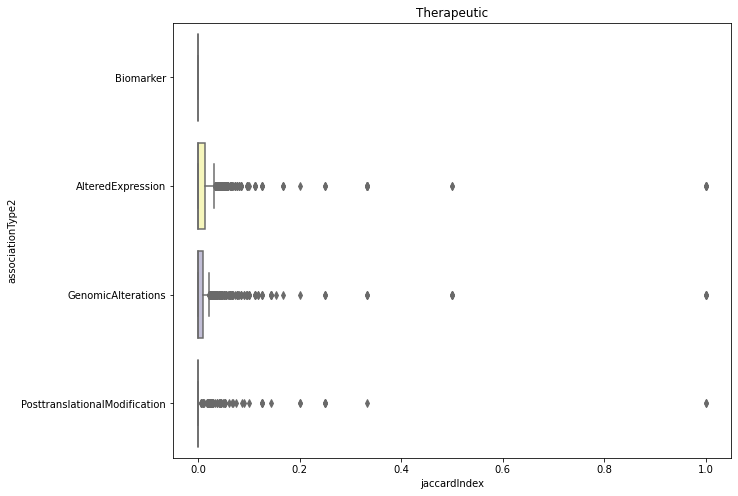

In [94]:
#Boxplots for Gene Exploration:
for i, associationType in enumerate(resultGE.associationType1.unique(), 1): #Iterating through each unique association Type
    data = resultGE[resultGE.associationType1 == associationType] #Filtering by association Type
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(x = 'jaccardIndex', y = 'associationType2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(associationType)

In [95]:
# Reorganizing the Dataset to Obtain the Median Values for Each Association Type Combination:
# This new dataset will have one row for each association type combination, a set of the jaccard Indices for that association type combination, and a median of the values for each of those sets. Those median values are what will be placed in the heatmap
resultGE2 = resultGE.drop(columns = ['diseaseNID', 'geneNID1', 'geneNID2'])
resultGE2 = resultGE2.groupby(by = ['associationType1', 'associationType2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [96]:
#Adding the median jaccard scores into the dataset
jaccardsets = resultGE2['jaccardIndex']
medians = []
for aset in jaccardsets:
    medians.append(statistics.median(aset))
resultGE2['Median'] = medians
resultGE2

,associationType1,associationType2,jaccardIndex,Median
0,AlteredExpression,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
1,AlteredExpression,GenomicAlterations,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303
2,AlteredExpression,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.037440435670524165, 0.035190...",0.000000
3,AlteredExpression,Therapeutic,"[0.0, 0.016666666666666666, 0.0, 0.0, 0.002118...",0.000000
4,Biomarker,AlteredExpression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
5,Biomarker,GenomicAlterations,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
6,Biomarker,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
7,Biomarker,Therapeutic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000
8,GenomicAlterations,AlteredExpression,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303
9,GenomicAlterations,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000


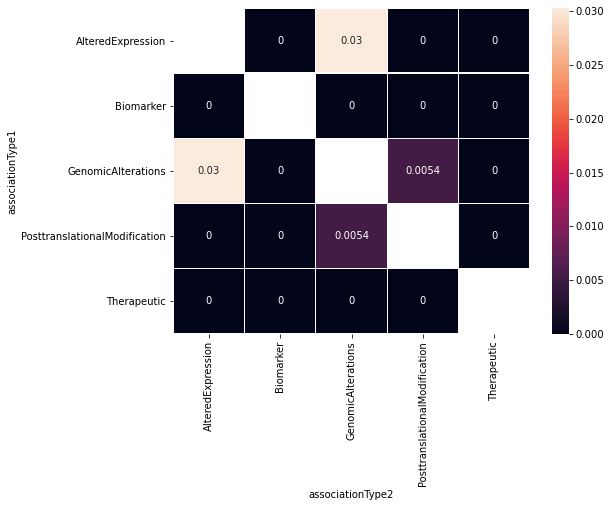

In [97]:
#Recategorized Dataset Heatmap with Unique Biomarker Rows Median:
resultGE3 = resultGE2.pivot("associationType1", "associationType2", "Median")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

The heatmap is again mapping each of the association types to every other association type in the dataset. Overall, there are not high correlations whatsoever between association types, as can be seen by all the black squares in the heatmap, but the highest correlations are seen between Altered Expression and Genomic Alterations, squared in red, which are siblings in our association type hierarchy. I believe we were expecting these correlations to be low anyways because they are all pretty different from each other. While Genomic Alterations, Altered Expression, and Posttranslational Modification are children of Biomarker, anything that would show that they are correlated has been removed with our recategorization (we took only the unique biomarker rows). We can visually see that they have no correlation by looking at the Biomarker row in both heatmaps. All the way across are 0’s, suggesting that we correctly kept only unique Biomarker associations. 

In [98]:
#Adding the mean jaccard scores into the dataset
meansets = resultGE2['jaccardIndex']
means = []
for aset in meansets:
    means.append(statistics.mean(aset))
resultGE2['Mean'] = means
resultGE2

,associationType1,associationType2,jaccardIndex,Median,Mean
0,AlteredExpression,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
1,AlteredExpression,GenomicAlterations,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303,0.079792
2,AlteredExpression,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.037440435670524165, 0.035190...",0.000000,0.027549
3,AlteredExpression,Therapeutic,"[0.0, 0.016666666666666666, 0.0, 0.0, 0.002118...",0.000000,0.021436
4,Biomarker,AlteredExpression,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
5,Biomarker,GenomicAlterations,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
6,Biomarker,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
7,Biomarker,Therapeutic,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000
8,GenomicAlterations,AlteredExpression,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303,0.079792
9,GenomicAlterations,Biomarker,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.000000,0.000000


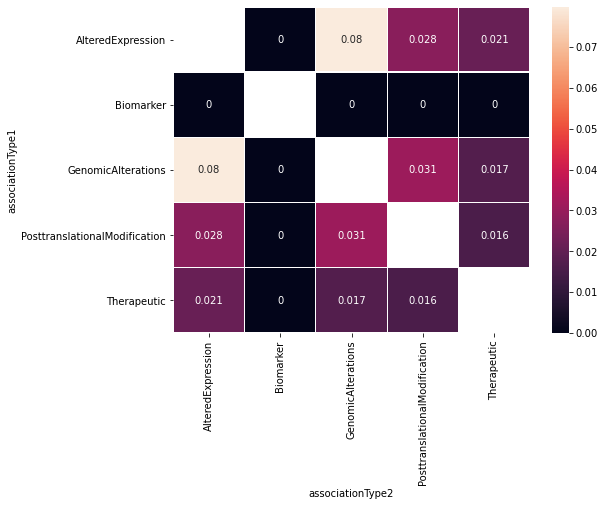

In [99]:
#Recategorized Dataset Heatmap with Unique Biomarker Rows Mean:
resultGE4 = resultGE2.pivot("associationType1", "associationType2", "Mean")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE4, annot = True, linewidths = .25)

The heatmap using the mean Jaccard Index was also plotted to show the large effect of outliers.

# Recategorized Dataset (All Biomarker):

Next, we wanted to verify that if we included all data for Biomarker, that we would see increases in the median correlation coefficients between Biomarker and every other chosen association type. We also wanted to see if this categorization would end up being more useful for the next steps based on the results found. We did this by using the same dataset except instead of unique biomarker data, we used the original biomarker rows before propagation and recategorization. This dataset was then filtered to be capable of being used for the supervised machine learning model we later use on a curated dataset.

In [100]:
#Splitting the association types in the propagated association type set each into their own line
result = pd.DataFrame([(c, tup.diseaseNID, tup.geneNID, tup.associationType) for tup in nonbm.itertuples() for c in tup.propagatedAssociationTypes])
result = result.rename(columns= {0: 'propagatedAssociationType', 1: 'diseaseNID', 2: 'geneNID', 3: 'ogAssociationTypes'})
#Now we only keep rows that have our other four chosen association types
result2 = result[result['propagatedAssociationType'].map(lambda d: d == 'AlteredExpression' or d =='GenomicAlterations' or d == 'Therapeutic' or d == 'PosttranslationalModification') ]
result2

,propagatedAssociationType,diseaseNID,geneNID,ogAssociationTypes
0,AlteredExpression,1317,1088,{AlteredExpression}
2,AlteredExpression,1338,1088,{AlteredExpression}
4,AlteredExpression,1741,1088,{AlteredExpression}
6,PosttranslationalModification,2107,1088,{PosttranslationalModification}
8,AlteredExpression,2592,1088,{AlteredExpression}
...,...,...,...,...
1553751,AlteredExpression,29802,18834,{AlteredExpression}
1553753,AlteredExpression,29802,18837,{AlteredExpression}
1553757,GenomicAlterations,30104,25482,{CausalMutation}
1553761,GenomicAlterations,30147,21709,{CausalMutation}


In [101]:
#Grabbing all Biomarker data from original dataset (not just gene-disease pairs that had biomarker as their only listed original association type)
bm = dfOG[dfOG['associationType'].map(lambda d: d) == 'Biomarker']
bm2 = bm.groupby(by = ['diseaseNID', 'geneNID'])['associationType'].apply(lambda x: set(x))
bm2 = bm2.reset_index()
bm2['propagatedAssociationType'] = bm2['associationType']
bm2['propagatedAssociationType'] = bm2['propagatedAssociationType'].apply(lambda x: ("".join(x)))
bm2 = bm2.rename(columns={'associationType': 'ogAssociationTypes'})
bm2

,diseaseNID,geneNID,ogAssociationTypes,propagatedAssociationType
0,1,1088,{Biomarker},Biomarker
1,1,3070,{Biomarker},Biomarker
2,2,10721,{Biomarker},Biomarker
3,3,54,{Biomarker},Biomarker
4,3,170,{Biomarker},Biomarker
...,...,...,...,...
766860,30292,9805,{Biomarker},Biomarker
766861,30292,18471,{Biomarker},Biomarker
766862,30292,19792,{Biomarker},Biomarker
766863,30293,6353,{Biomarker},Biomarker


In [102]:
#Appending the All Biomarker and 4 Other Association Type Datasets Together:
result3 = result2.append(bm2)
result3 = result3[["diseaseNID", "geneNID", "propagatedAssociationType", "ogAssociationTypes"]]
result3

,diseaseNID,geneNID,propagatedAssociationType,ogAssociationTypes
0,1317,1088,AlteredExpression,{AlteredExpression}
2,1338,1088,AlteredExpression,{AlteredExpression}
4,1741,1088,AlteredExpression,{AlteredExpression}
6,2107,1088,PosttranslationalModification,{PosttranslationalModification}
8,2592,1088,AlteredExpression,{AlteredExpression}
...,...,...,...,...
766860,30292,9805,Biomarker,{Biomarker}
766861,30292,18471,Biomarker,{Biomarker}
766862,30292,19792,Biomarker,{Biomarker}
766863,30293,6353,Biomarker,{Biomarker}


In [103]:
result3.to_csv('OutputFiles/AllBiomarker.csv', index = False)

In [104]:
#Getting rid of ogAssociationTypes
threeCol = result3.drop(columns = 'ogAssociationTypes')
threeCol

,diseaseNID,geneNID,propagatedAssociationType
0,1317,1088,AlteredExpression
2,1338,1088,AlteredExpression
4,1741,1088,AlteredExpression
6,2107,1088,PosttranslationalModification
8,2592,1088,AlteredExpression
...,...,...,...
766860,30292,9805,Biomarker
766861,30292,18471,Biomarker
766862,30292,19792,Biomarker
766863,30293,6353,Biomarker


In [105]:
# Dataset with diseaseNID, associationType, and Counts of Genes per Disease by Association Type (Log and non-log):
logSumDisease = threeCol.groupby(by = ['diseaseNID', 'propagatedAssociationType']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Association Type')
logSumDisease['Log of Counts of Genes per Disease by Association Type'] = np.log10(logSumDisease['Counts of Genes per Disease by Association Type'])
logSumDisease

,diseaseNID,propagatedAssociationType,Counts of Genes per Disease by Association Type,Log of Counts of Genes per Disease by Association Type
0,2107,Biomarker,8391,3.923814
1,431,Biomarker,7161,3.854974
2,13959,Biomarker,6841,3.835120
3,2107,AlteredExpression,6792,3.831998
4,10815,Biomarker,5346,3.728029
...,...,...,...,...
58010,9190,AlteredExpression,1,0.000000
58011,9192,GenomicAlterations,1,0.000000
58012,9193,Biomarker,1,0.000000
58013,9196,AlteredExpression,1,0.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Association Type', ylabel='propagatedAssociationType'>

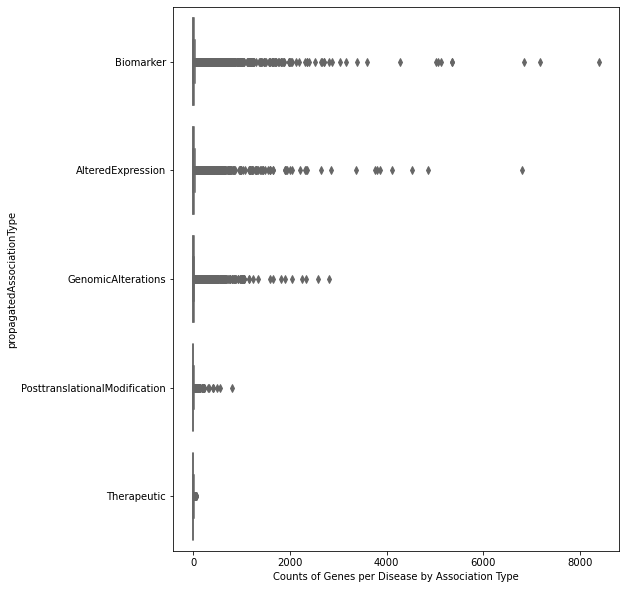

In [106]:
#Boxplot of Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Counts of Genes per Disease by Association Type',
                 data = logSumDisease, palette="Set3", orient = 'h')

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Association Type', ylabel='propagatedAssociationType'>

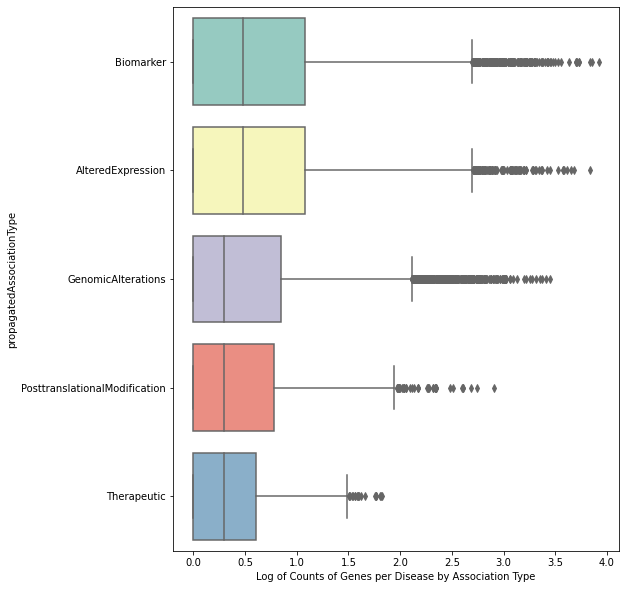

In [107]:
#Boxplot of Log of Counts of Genes per Disease for each Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Log of Counts of Genes per Disease by Association Type',
                 data = logSumDisease, palette="Set3", orient = 'h')

In [108]:
# Dataset with Fraction of Genes for a Disease per Association Type:
logSumDisease2 = threeCol.groupby(by = ['diseaseNID']).size().sort_values(ascending=False).reset_index(name = 'Counts of Diseases')
result = logSumDisease.merge(logSumDisease2)
result['Ratio'] = result['Counts of Genes per Disease by Association Type']/result['Counts of Diseases']
result

,diseaseNID,propagatedAssociationType,Counts of Genes per Disease by Association Type,Log of Counts of Genes per Disease by Association Type,Counts of Diseases,Ratio
0,2107,Biomarker,8391,3.923814,18802,0.446282
1,2107,AlteredExpression,6792,3.831998,18802,0.361238
2,2107,GenomicAlterations,2802,3.447468,18802,0.149027
3,2107,PosttranslationalModification,802,2.904174,18802,0.042655
4,2107,Therapeutic,15,1.176091,18802,0.000798
...,...,...,...,...,...,...
58010,9183,GenomicAlterations,1,0.000000,1,1.000000
58011,9184,GenomicAlterations,1,0.000000,1,1.000000
58012,9187,Biomarker,1,0.000000,1,1.000000
58013,9188,Biomarker,1,0.000000,1,1.000000


<AxesSubplot:xlabel='Ratio', ylabel='propagatedAssociationType'>

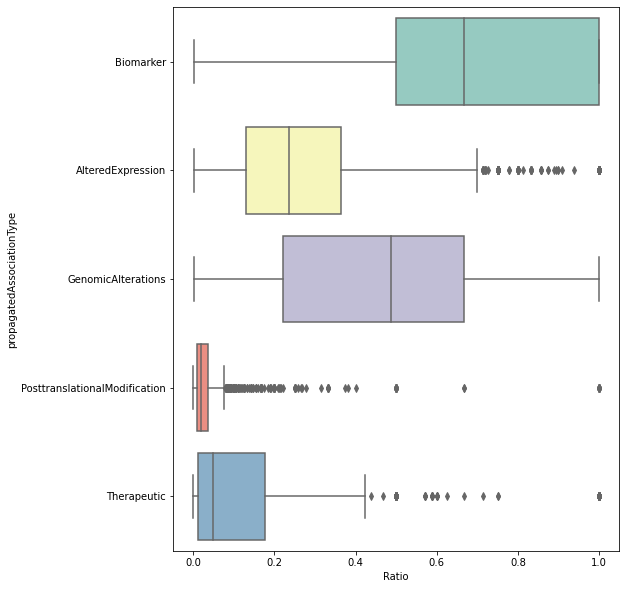

In [109]:
#Boxplot of Fraction of Genes for a Disease per Association Type:
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'propagatedAssociationType', x = 'Ratio',
                 data = result, palette="Set3", orient = 'h')

## Gene Comparison and Exploration:

In [110]:
# Creating Gene Sets for Each Association Type Based on Disease:
a = threeCol.groupby(by = ['diseaseNID', 'propagatedAssociationType'])['geneNID'].apply(lambda x: set(x))
a = a.reset_index()
# Creating Sets of association Types Based on Disease
a2 = a.groupby(by = ['diseaseNID'])['propagatedAssociationType'].apply(lambda x: set(x))
a2 = a2.to_frame().reset_index()
# Creating the Different Possible Combinations of Association Types for Each Disease:
from itertools import product
a2['permutations'] = a2['propagatedAssociationType'].apply(lambda r: list(permutations(r,2)))

In [111]:
# Removing the Diseases that Only Hold One Association Type:
a3 = a2[a2['permutations'].map(lambda d: len(d)) > 0]
# Making a Separate Row for Each Combination:
resultGE = pd.DataFrame([(c, tup.diseaseNID) for tup in a3.itertuples() for c in tup.permutations])
resultGE = resultGE.rename(columns={0: 'Combos', 1: 'diseaseNID'})
# Separating the Created Combinations into 2 Columns:
resultGE[['associationType1','associationType2']] = pd.DataFrame(resultGE.Combos.tolist(), index= resultGE.index)
resultGE

,Combos,diseaseNID,associationType1,associationType2
0,"(GenomicAlterations, Biomarker)",3,GenomicAlterations,Biomarker
1,"(Biomarker, GenomicAlterations)",3,Biomarker,GenomicAlterations
2,"(AlteredExpression, GenomicAlterations)",5,AlteredExpression,GenomicAlterations
3,"(AlteredExpression, Biomarker)",5,AlteredExpression,Biomarker
4,"(GenomicAlterations, AlteredExpression)",5,GenomicAlterations,AlteredExpression
...,...,...,...,...
81781,"(AlteredExpression, Biomarker)",30292,AlteredExpression,Biomarker
81782,"(GenomicAlterations, AlteredExpression)",30292,GenomicAlterations,AlteredExpression
81783,"(GenomicAlterations, Biomarker)",30292,GenomicAlterations,Biomarker
81784,"(Biomarker, AlteredExpression)",30292,Biomarker,AlteredExpression


In [112]:
#Finding the associated gene sets
arowList = []
arow2List = []
for index, row in resultGE.iterrows():
    midrow = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propagatedAssociationType'] == row['associationType1'])]
    arowList.append(midrow.iloc[0]['geneNID'])
    
    midrow2 = a.loc[(a['diseaseNID'] == row['diseaseNID']) & (a['propagatedAssociationType'] == row['associationType2'])]
    arow2List.append(midrow2.iloc[0]['geneNID'])

In [113]:
#Adding the gene sets into the dataset
resultGE['geneNID1'] = arowList
resultGE['geneNID2'] = arow2List
resultGE = resultGE.drop(columns = ['Combos'])
resultGE['jaccardIndex'] = np.nan
#Adding in the jaccard similarity coefficient
resultGE['jaccardIndex'] = resultGE.apply(f, axis = 1)
resultGE

,diseaseNID,associationType1,associationType2,geneNID1,geneNID2,jaccardIndex
0,3,GenomicAlterations,Biomarker,"{4711, 6417, 5458, 1813, 3065, 17182}","{522, 525, 7694, 5650, 5139, 11283, 12826, 156...",0.009709
1,3,Biomarker,GenomicAlterations,"{522, 525, 7694, 5650, 5139, 11283, 12826, 156...","{4711, 6417, 5458, 1813, 3065, 17182}",0.009709
2,5,AlteredExpression,GenomicAlterations,"{3288, 1924}","{5304, 5241, 8699, 2126}",0.000000
3,5,AlteredExpression,Biomarker,"{3288, 1924}","{129, 4577, 3559, 11754, 1489, 3799, 3288, 1567}",0.111111
4,5,GenomicAlterations,AlteredExpression,"{5304, 5241, 8699, 2126}","{3288, 1924}",0.000000
...,...,...,...,...,...,...
81781,30292,AlteredExpression,Biomarker,"{3833, 11963, 2493, 270}","{18471, 1738, 3551, 9805, 46, 270, 19792, 6738...",0.058824
81782,30292,GenomicAlterations,AlteredExpression,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{3833, 11963, 2493, 270}",0.100000
81783,30292,GenomicAlterations,Biomarker,"{2403, 1738, 9805, 270, 6738, 3829, 4057}","{18471, 1738, 3551, 9805, 46, 270, 19792, 6738...",0.400000
81784,30292,Biomarker,AlteredExpression,"{18471, 1738, 3551, 9805, 46, 270, 19792, 6738...","{3833, 11963, 2493, 270}",0.058824


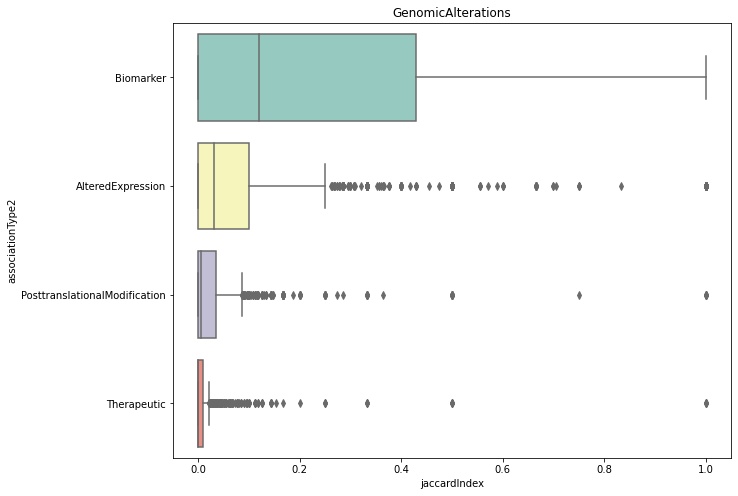

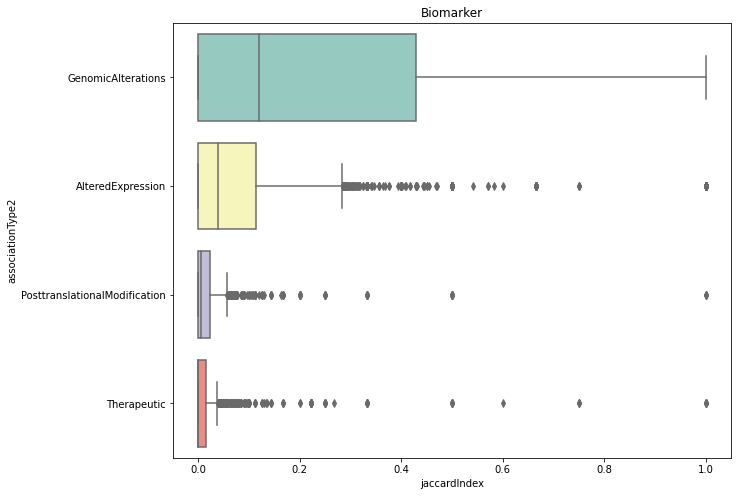

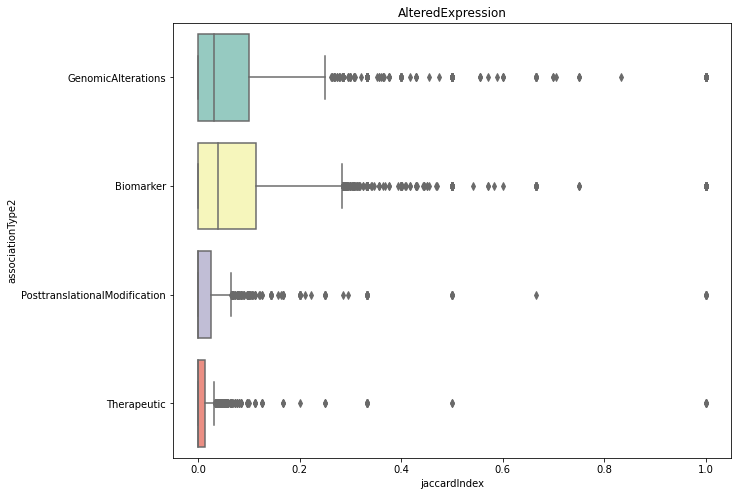

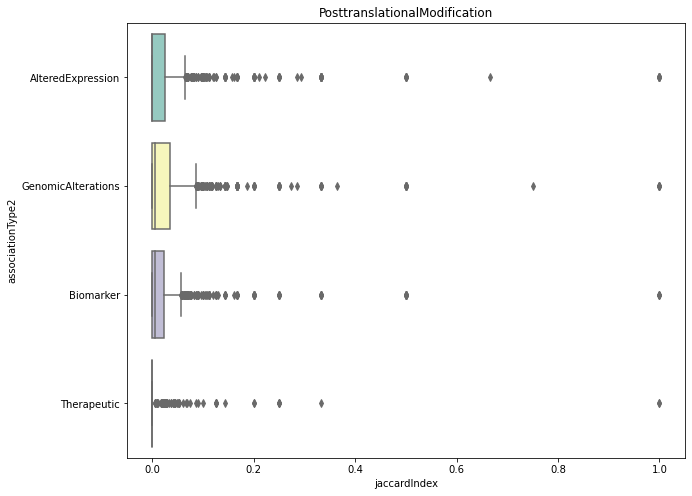

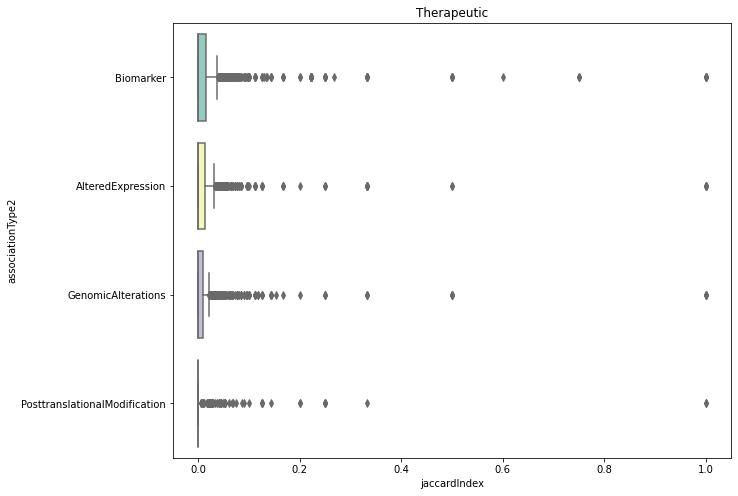

In [114]:
#Boxplots for Gene Exploration:
for i, associationType in enumerate(resultGE.associationType1.unique(), 1): #Iterating through each unique association Type
    data = resultGE[resultGE.associationType1 == associationType] #Filtering by association Type
    fig, ax = plt.subplots(figsize = (10,8))
    sns.boxplot(x = 'jaccardIndex', y = 'associationType2',
                 data = data, palette="Set3", orient = 'h')
    plt.title(associationType)

In [115]:
# Reorganizing the Dataset to Obtain the Median Values for Each Association Type Combination:
# This new dataset will have one row for each association type combination, a set of the jaccard Indices for that association type combination, and a median of the values for each of those sets. Those median values are what will be placed in the heatmap
resultGE2 = resultGE.drop(columns = ['diseaseNID', 'geneNID1', 'geneNID2'])
resultGE2 = resultGE2.groupby(by = ['associationType1', 'associationType2'])['jaccardIndex'].apply(lambda x: list(x))
resultGE2 = resultGE2.reset_index()

In [116]:
#Adding the median jaccard scores into the dataset
jaccardsets = resultGE2['jaccardIndex']
medians = []
for aset in jaccardsets:
    medians.append(statistics.median(aset))
resultGE2['Median'] = medians
resultGE2

,associationType1,associationType2,jaccardIndex,Median
0,AlteredExpression,Biomarker,"[0.1111111111111111, 0.02456140350877193, 0.06...",0.039286
1,AlteredExpression,GenomicAlterations,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303
2,AlteredExpression,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.037440435670524165, 0.035190...",0.000000
3,AlteredExpression,Therapeutic,"[0.0, 0.016666666666666666, 0.0, 0.0, 0.002118...",0.000000
4,Biomarker,AlteredExpression,"[0.1111111111111111, 0.02456140350877193, 0.06...",0.039286
5,Biomarker,GenomicAlterations,"[0.009708737864077669, 0.0, 0.0343642611683848...",0.120000
6,Biomarker,PosttranslationalModification,"[0.0073964497041420114, 0.0, 0.018867924528301...",0.006090
7,Biomarker,Therapeutic,"[0.0, 0.0, 0.006289308176100629, 0.03703703703...",0.000000
8,GenomicAlterations,AlteredExpression,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303
9,GenomicAlterations,Biomarker,"[0.009708737864077669, 0.0, 0.0343642611683848...",0.120000


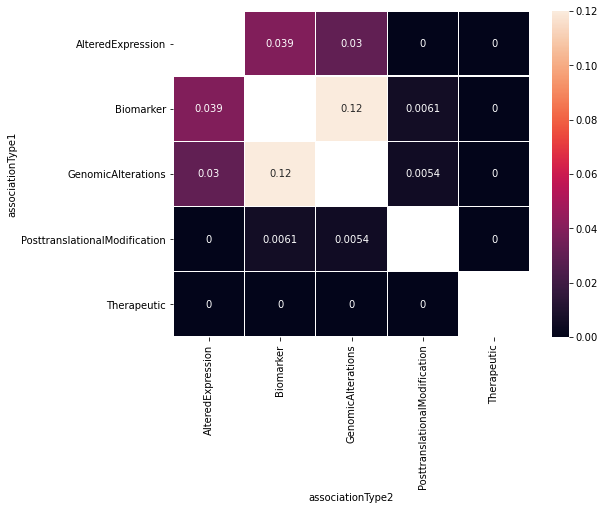

In [117]:
#Recategorized Dataset Heatmap with Non-Unique Biomarker Rows Median:
resultGE3 = resultGE2.pivot("associationType1", "associationType2", "Median")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE3, annot = True, linewidths = .25)

This heatmap, comparing median correlation scores for association pairs, was created to understand this dataset, and overall, there are higher correlations between association types with this recategorization than with the unique biomarker categorization, but all these values are still very low. The highest correlations are tan or purple in color and can be seen between Biomarker/Altered Expression and Biomarker/Genomic Alterations, which we would hope to see. All we changed really was adding back in biomarker rows that were removed because that gene-disease pair was labeled under another association type as well. Thus, we have verified that these added rows are what increased the correlation scores. 

In [118]:
#Adding the mean jaccard scores into the dataset
meansets = resultGE2['jaccardIndex']
means = []
for aset in meansets:
    means.append(statistics.mean(aset))
resultGE2['Mean'] = means
resultGE2

,associationType1,associationType2,jaccardIndex,Median,Mean
0,AlteredExpression,Biomarker,"[0.1111111111111111, 0.02456140350877193, 0.06...",0.039286,0.084805
1,AlteredExpression,GenomicAlterations,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303,0.079792
2,AlteredExpression,PosttranslationalModification,"[0.0, 0.0, 0.0, 0.037440435670524165, 0.035190...",0.000000,0.027549
3,AlteredExpression,Therapeutic,"[0.0, 0.016666666666666666, 0.0, 0.0, 0.002118...",0.000000,0.021436
4,Biomarker,AlteredExpression,"[0.1111111111111111, 0.02456140350877193, 0.06...",0.039286,0.084805
5,Biomarker,GenomicAlterations,"[0.009708737864077669, 0.0, 0.0343642611683848...",0.120000,0.282661
6,Biomarker,PosttranslationalModification,"[0.0073964497041420114, 0.0, 0.018867924528301...",0.006090,0.022777
7,Biomarker,Therapeutic,"[0.0, 0.0, 0.006289308176100629, 0.03703703703...",0.000000,0.026303
8,GenomicAlterations,AlteredExpression,"[0.0, 0.022727272727272728, 0.0857142857142857...",0.030303,0.079792
9,GenomicAlterations,Biomarker,"[0.009708737864077669, 0.0, 0.0343642611683848...",0.120000,0.282661


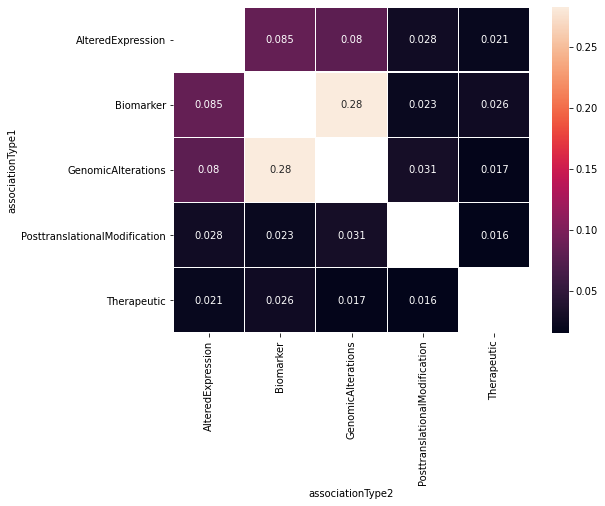

In [119]:
#Recategorized Dataset Heatmap with Non-Unique Biomarker Rows Mean:
resultGE4 = resultGE2.pivot("associationType1", "associationType2", "Mean")
fig, ax = plt.subplots(figsize=(8,6))   
ax = sns.heatmap(resultGE4, annot = True, linewidths = .25)

We again created a heatmap using the mean Jaccard Index to demonstrate outliers did have an impact on the dataset

## Association Type Filtering on All Biomarker Recategorized Propagated Dataset

In [120]:
#Using the diseasemappings file from DisGeNET to get DOID formatted diseases
diseasemappings = pd.read_csv('DisGeNETFiles/disease_mappings.tsv', sep = '\t')
diseasemappings = diseasemappings.drop(columns = ['vocabularyName'])
diseasemappings = diseasemappings.rename(columns = {'name': 'diseaseName'})
#Only keeping disease-gene pairs with DO as the vocabulary name
diseasemappings = diseasemappings[diseasemappings['vocabulary'].map(lambda d: d == 'DO')]
diseasemappings

,diseaseId,diseaseName,vocabulary,code
0,C0018923,Hemangiosarcoma,DO,0001816
1,C0854893,Angiosarcoma non-metastatic,DO,0001816
2,C0033999,Pterygium,DO,0002116
3,C0025517,Metabolic Diseases,DO,0014667
4,C0155862,Streptococcal pneumonia,DO,0040084
...,...,...,...,...
13631,C0272192,Familial eosinophilia,DO,999
13632,C0014457,Eosinophilia,DO,999
13633,C0311368,Idiopathic eosinophilia,DO,999
13634,C0020615,Hypoglycemia,DO,9993


In [121]:
#Merging propagated recategorized all-biomarker dataset (result3) with diseaseinfo to get the diseaseId and disease name)
AllBiomarker = result3.merge(diseaseinfo)
AllBiomarker

,diseaseNID,geneNID,propagatedAssociationType,ogAssociationTypes,diseaseId,diseaseName,type
0,1317,1088,AlteredExpression,{AlteredExpression},C0018939,Hematological Disease,group
1,1317,4937,GenomicAlterations,{GeneticVariation},C0018939,Hematological Disease,group
2,1317,5486,AlteredExpression,{AlteredExpression},C0018939,Hematological Disease,group
3,1317,2126,GenomicAlterations,{GeneticVariation},C0018939,Hematological Disease,group
4,1317,5241,GenomicAlterations,"{GeneticVariation, Biomarker}",C0018939,Hematological Disease,group
...,...,...,...,...,...,...,...
1411807,30279,722,Biomarker,{Biomarker},C4755276,Primary CD59 deficiency,disease
1411808,30282,2524,Biomarker,{Biomarker},C4755297,Somatomammotropinoma,disease
1411809,30282,3288,Biomarker,{Biomarker},C4755297,Somatomammotropinoma,disease
1411810,30293,6353,Biomarker,{Biomarker},C4759434,PF-ILD-progressive fibrosing interstitial lung...,disease


In [122]:
#Merging diseasemappings with AllBiomarker dataset to get necessary info to create DOIDs:
first = diseasemappings.merge(AllBiomarker)
first['DOID'] = ('DOID:' + (first['code']))
first

,diseaseId,diseaseName,vocabulary,code,diseaseNID,geneNID,propagatedAssociationType,ogAssociationTypes,type,DOID
0,C0018923,Hemangiosarcoma,DO,0001816,1312,1567,AlteredExpression,{AlteredExpression},disease,DOID:0001816
1,C0018923,Hemangiosarcoma,DO,0001816,1312,4323,GenomicAlterations,"{GeneticVariation, Biomarker}",disease,DOID:0001816
2,C0018923,Hemangiosarcoma,DO,0001816,1312,5486,AlteredExpression,{AlteredExpression},disease,DOID:0001816
3,C0018923,Hemangiosarcoma,DO,0001816,1312,3799,AlteredExpression,"{GeneticVariation, AlteredExpression}",disease,DOID:0001816
4,C0018923,Hemangiosarcoma,DO,0001816,1312,3799,GenomicAlterations,"{GeneticVariation, AlteredExpression}",disease,DOID:0001816
...,...,...,...,...,...,...,...,...,...,...
1609330,C0020615,Hypoglycemia,DO,9993,1514,19729,Biomarker,{Biomarker},disease,DOID:9993
1609331,C0020615,Hypoglycemia,DO,9993,1514,19781,Biomarker,{Biomarker},disease,DOID:9993
1609332,C0020615,Hypoglycemia,DO,9993,1514,21817,Biomarker,{Biomarker},disease,DOID:9993
1609333,C0877208,Peripartum cardiomyopathy,DO,9997,12770,8094,GenomicAlterations,{GeneticVariation},phenotype,DOID:9997


In [123]:
#Grouping the genes into gene sets
resultDOID = first.groupby(by = ['DOID', 'diseaseName', 'propagatedAssociationType'])['geneNID'].apply(lambda x: set(x))
resultDOID = resultDOID.reset_index()
resultDOID

,DOID,diseaseName,propagatedAssociationType,geneNID
0,DOID:0001816,Angiosarcoma non-metastatic,Biomarker,"{9713, 3285, 2438}"
1,DOID:0001816,Hemangiosarcoma,AlteredExpression,"{3713, 778, 3084, 780, 1553, 5778, 10260, 151,..."
2,DOID:0001816,Hemangiosarcoma,Biomarker,"{11784, 6156, 3090, 26130, 3615, 4639, 4138, 1..."
3,DOID:0001816,Hemangiosarcoma,GenomicAlterations,"{3840, 26117, 778, 1035, 5132, 1935, 9626, 425..."
4,DOID:0001816,Hemangiosarcoma,PosttranslationalModification,"{5241, 229, 13997}"
...,...,...,...,...
32934,DOID:9993,Hypoglycemia,Biomarker,"{2048, 2056, 2066, 6163, 27, 28, 12316, 30, 32..."
32935,DOID:9993,Hypoglycemia,GenomicAlterations,"{5122, 3078, 4111, 4627, 6684, 28, 31, 4138, 2..."
32936,DOID:9993,Hypoglycemia,PosttranslationalModification,{4032}
32937,DOID:9997,Peripartum cardiomyopathy,Biomarker,{4936}


In [10]:
#Importing the Ontology Class and calling it disease_ontology
from ontology import Ontology
disease_ontology = Ontology()
disease_ontology.load("doid.obo")

In [11]:
#Getting all descendants from our 14 higher level terms and adding them into one file called desired
cardio = disease_ontology.descendants('DOID:1287')
endo = disease_ontology.descendants('DOID:28')
gastro = disease_ontology.descendants('DOID:77')
hemat = disease_ontology.descendants('DOID:74')
immune = disease_ontology.descendants('DOID:2914')
integu = disease_ontology.descendants('DOID:16')
musc = disease_ontology.descendants('DOID:17')
nervous = disease_ontology.descendants('DOID:863')
reprod = disease_ontology.descendants('DOID:229')
respir = disease_ontology.descendants('DOID:1579')
thoracic = disease_ontology.descendants('DOID:0060118')
urinary = disease_ontology.descendants('DOID:18')
metabolism = disease_ontology.descendants('DOID:0014667')
mhealth = disease_ontology.descendants('DOID:150')

desired = set().union(cardio).union(endo).union(gastro).union(hemat).union(immune).union(integu).union(musc).union(nervous).union(reprod).union(respir).union(thoracic).union(urinary).union(metabolism).union(mhealth)

In [12]:
#Also adding in the 14 higher level terms themselves into desired
desired.add('DOID:1287')
desired.add('DOID:28')
desired.add('DOID:77')
desired.add('DOID:74')
desired.add('DOID:2914')
desired.add('DOID:16')
desired.add('DOID:17')
desired.add('DOID:863')
desired.add('DOID:229')
desired.add('DOID:1579')
desired.add('DOID:0060118')
desired.add('DOID:18')
desired.add('DOID:0014667')
desired.add('DOID:150')

In [127]:
#All diseases from resultDOID that fall in the 14 higher level terms 
#(please excuse the name I used, I was a bit lazy to change it for all subsequent code)
desired12 = resultDOID[resultDOID['DOID'].isin(desired)]
desired12

,DOID,diseaseName,propagatedAssociationType,geneNID
6,DOID:0002116,Pterygium,AlteredExpression,"{4613, 6149, 4106, 26130, 5653, 5141, 2585, 18..."
7,DOID:0002116,Pterygium,Biomarker,"{4613, 1034, 2581, 5141, 5653, 3613, 2590, 720..."
8,DOID:0002116,Pterygium,GenomicAlterations,"{10503, 2572, 2574, 3854, 5141, 1817, 3866, 45..."
9,DOID:0002116,Pterygium,PosttranslationalModification,"{1317, 778, 750, 26130, 5241}"
10,DOID:0002116,Pterygium,Therapeutic,{2501}
...,...,...,...,...
32934,DOID:9993,Hypoglycemia,Biomarker,"{2048, 2056, 2066, 6163, 27, 28, 12316, 30, 32..."
32935,DOID:9993,Hypoglycemia,GenomicAlterations,"{5122, 3078, 4111, 4627, 6684, 28, 31, 4138, 2..."
32936,DOID:9993,Hypoglycemia,PosttranslationalModification,{4032}
32937,DOID:9997,Peripartum cardiomyopathy,Biomarker,{4936}


In [128]:
#Temporarily removing the diseaseName column to make dictionaries easier
desired12short = desired12.drop(columns = 'diseaseName')
#Creating a dictionary where the keys are the five association types, and the labels are the data available for those association types (DOID, geneNID) in a dataset format 
dict_of_sources = dict(iter(desired12short.groupby('propagatedAssociationType')))

In [129]:
#Creaing a separate dictionary for each association type
AE_dict = dict(zip(dict_of_sources['AlteredExpression'].DOID, dict_of_sources['AlteredExpression'].geneNID))
BM_human_dict = dict(zip(dict_of_sources['Biomarker'].DOID, dict_of_sources['Biomarker'].geneNID))
GA_dict = dict(zip(dict_of_sources['GenomicAlterations'].DOID, dict_of_sources['GenomicAlterations'].geneNID))
PTM_dict = dict(zip(dict_of_sources['PosttranslationalModification'].DOID, dict_of_sources['PosttranslationalModification'].geneNID))
T_dict = dict(zip(dict_of_sources['Therapeutic'].DOID, dict_of_sources['Therapeutic'].geneNID))

In [130]:
#Creating a propagated dictionary for each association type
AE_prop = disease_ontology.propagate(AE_dict)
BM_prop = disease_ontology.propagate(BM_human_dict)
GA_prop = disease_ontology.propagate(GA_dict)
PTM_prop = disease_ontology.propagate(PTM_dict)
T_prop = disease_ontology.propagate(T_dict)

In [131]:
#Turning each dictionary into a dataframe
AE = pd.DataFrame([k for k in AE_prop.items()], columns=['DOID', 'geneSet'])
BM = pd.DataFrame([k for k in BM_prop.items()], columns=['DOID', 'geneSet'])
GA = pd.DataFrame([k for k in GA_prop.items()], columns=['DOID', 'geneSet'])
PTM = pd.DataFrame([k for k in PTM_prop.items()], columns=['DOID', 'geneSet'])
T = pd.DataFrame([k for k in T_prop.items()], columns=['DOID', 'geneSet'])

In [132]:
#Creating a column in each association type dataset for the name of the dataset (so that this info will be available once the datasets are apended back together)
#Note, I call them sources here, but they are really association types. It won't matter in the end because I will be changing the name of the column later
AE['source'] = 'AlteredExpression'
BM['source'] = 'Biomarker'
GA['source'] = 'GenomicAlterations'
PTM['source'] = 'PosttranslationalModification'
T['source'] = 'Therapeutic'

In [133]:
#Appending the datasets back together
propagated = AE.append(BM).append(GA).append(PTM).append(T)
propagated

,DOID,geneSet,source
0,DOID:0002116,"{3842, 8451, 4613, 6149, 10503, 3849, 4106, 77...",AlteredExpression
1,DOID:10124,"{1537, 4609, 5122, 2, 4613, 6149, 5640, 3593, ...",AlteredExpression
2,DOID:863,"{1, 2, 6, 7, 16396, 13, 14, 16398, 18, 19, 25,...",AlteredExpression
3,DOID:7,"{1, 2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, ...",AlteredExpression
4,DOID:5614,"{2, 4106, 13, 4112, 12304, 18, 20507, 4126, 32...",AlteredExpression
...,...,...,...
1029,DOID:9538,"{1066, 2501, 1063}",Therapeutic
1030,DOID:9673,{7854},Therapeutic
1031,DOID:9675,{5141},Therapeutic
1032,DOID:9854,{13623},Therapeutic


In [134]:
#Adding the disease name back into the dataset
templist = []
for index, row, in propagated.iterrows():
    templist.append(disease_ontology.nodes[row['DOID']]["name"])
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0002116,"{3842, 8451, 4613, 6149, 10503, 3849, 4106, 77...",AlteredExpression,pterygium
1,DOID:10124,"{1537, 4609, 5122, 2, 4613, 6149, 5640, 3593, ...",AlteredExpression,corneal disease
2,DOID:863,"{1, 2, 6, 7, 16396, 13, 14, 16398, 18, 19, 25,...",AlteredExpression,nervous system disease
3,DOID:7,"{1, 2, 4, 5, 6, 7, 9, 11, 12, 13, 14, 15, 16, ...",AlteredExpression,disease of anatomical entity
4,DOID:5614,"{2, 4106, 13, 4112, 12304, 18, 20507, 4126, 32...",AlteredExpression,eye disease
...,...,...,...,...
1029,DOID:9538,"{1066, 2501, 1063}",Therapeutic,multiple myeloma
1030,DOID:9673,{7854},Therapeutic,ulcerative stomatitis
1031,DOID:9675,{5141},Therapeutic,pulmonary emphysema
1032,DOID:9854,{13623},Therapeutic,lingual-facial-buccal dyskinesia


### Writing to GMT files: (in case we need this data for machine learning)

In [137]:
#I need to turn this dataset (specifically the geneSet column) into a string instead of a set for Anna's method to run:
isinstance(propagated.iloc[0]['geneSet'], set)

True

In [138]:
propagated['geneSet'] = (propagated['geneSet']).astype(str)
propagated['geneSet'] = propagated['geneSet'].apply(lambda x: set(x[1:-1].split(", ")))
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0002116,"{6149, 1776, 2465, 5335, 1658, 10503, 25069, 1...",AlteredExpression,pterygium
1,DOID:10124,"{6149, 1776, 3214, 696, 5335, 5426, 9942, 2030...",AlteredExpression,corneal disease
2,DOID:863,"{17216, 19537, 6282, 7643, 2299, 9937, 4726, 5...",AlteredExpression,nervous system disease
3,DOID:7,"{17216, 3831, 14265, 1910, 12114, 19537, 14880...",AlteredExpression,disease of anatomical entity
4,DOID:5614,"{6149, 8276, 3526, 20548, 767, 3602, 6282, 989...",AlteredExpression,eye disease
...,...,...,...,...
1029,DOID:9538,"{2501, 1066, 1063}",Therapeutic,multiple myeloma
1030,DOID:9673,{7854},Therapeutic,ulcerative stomatitis
1031,DOID:9675,{5141},Therapeutic,pulmonary emphysema
1032,DOID:9854,{13623},Therapeutic,lingual-facial-buccal dyskinesia


In [139]:
propagated.iloc[0]['geneSet']

{'1005',
 '10409',
 '10503',
 '1111',
 '1115',
 '1146',
 '1169',
 '1436',
 '1473',
 '16066',
 '161',
 '1622',
 '1624',
 '1658',
 '1776',
 '1821',
 '18421',
 '18466',
 '18468',
 '18474',
 '18480',
 '18488',
 '18869',
 '211',
 '2247',
 '2465',
 '25069',
 '2530',
 '2531',
 '2535',
 '2585',
 '26130',
 '2764',
 '2826',
 '2873',
 '2920',
 '3123',
 '3138',
 '3139',
 '3140',
 '3143',
 '3144',
 '3215',
 '3285',
 '3326',
 '3415',
 '3551',
 '3713',
 '3833',
 '3842',
 '3849',
 '400',
 '4106',
 '4151',
 '434',
 '4515',
 '4521',
 '4523',
 '4524',
 '4526',
 '4529',
 '4613',
 '4686',
 '4791',
 '4792',
 '4857',
 '50',
 '5036',
 '5057',
 '5064',
 '5106',
 '5119',
 '5141',
 '5215',
 '5241',
 '5335',
 '5434',
 '5436',
 '5441',
 '5449',
 '5653',
 '5970',
 '6149',
 '621',
 '6858',
 '704',
 '7228',
 '7555',
 '7650',
 '778',
 '8451',
 '9707'}

In [140]:
#Creating a dictionary for each association type (key), with the labels being DOID, geneSet, and diseaseName in a dataset format
dict_of_associations = dict(iter(propagated.groupby('source')))

In [141]:
for source in dict_of_associations:
    write_gmt(filename = ("OutputFiles/gmtFiles/" + source + "Filtered.gmt"), names = (dict_of_associations[source].set_index('DOID').to_dict()['diseaseName']), 
              labels = (dict_of_associations[source].set_index('DOID').to_dict()['geneSet']))

In [142]:
#Recreating Boxplots (since we have filtered the dataset a little bit):

#Separating gene sets into separate rows, one for each gene-disease pair
dfsep = pd.DataFrame([(c, tup.DOID, tup.source) for tup in propagated.itertuples() for c in tup.geneSet])
dfsep = dfsep.rename(columns= {0: 'geneId', 1: 'propagatedDOID', 2: 'source'})
dfsep

,geneId,propagatedDOID,source
0,6149,DOID:0002116,AlteredExpression
1,1776,DOID:0002116,AlteredExpression
2,2465,DOID:0002116,AlteredExpression
3,5335,DOID:0002116,AlteredExpression
4,1658,DOID:0002116,AlteredExpression
...,...,...,...
1856156,3065,DOID:9975,Therapeutic
1856157,7150,DOID:9975,Therapeutic
1856158,1743,DOID:9975,Therapeutic
1856159,6689,DOID:9975,Therapeutic


In [143]:
#Dataset with Counts of Genes per Disease by Propagated Association Type (Log and non-log) for Boxplots
SumDisease = dfsep.groupby(by = ['propagatedDOID', 'source']).size().sort_values(ascending=False).reset_index(name = 'Counts of Genes per Disease by Propagated Association Type')
SumDisease['Log of Counts of Genes per Disease by Propagated Association Type'] = np.log10(SumDisease['Counts of Genes per Disease by Propagated Association Type'])
SumDisease

,propagatedDOID,source,Counts of Genes per Disease by Propagated Association Type,Log of Counts of Genes per Disease by Propagated Association Type
0,DOID:4,Biomarker,14661,4.166164
1,DOID:7,Biomarker,14146,4.150634
2,DOID:4,GenomicAlterations,12428,4.094401
3,DOID:7,GenomicAlterations,11417,4.057552
4,DOID:4,AlteredExpression,11156,4.047509
...,...,...,...,...
16009,DOID:1114,Biomarker,1,0.000000
16010,DOID:11130,PosttranslationalModification,1,0.000000
16011,DOID:11126,Biomarker,1,0.000000
16012,DOID:11126,AlteredExpression,1,0.000000


<AxesSubplot:xlabel='Counts of Genes per Disease by Propagated Association Type', ylabel='source'>

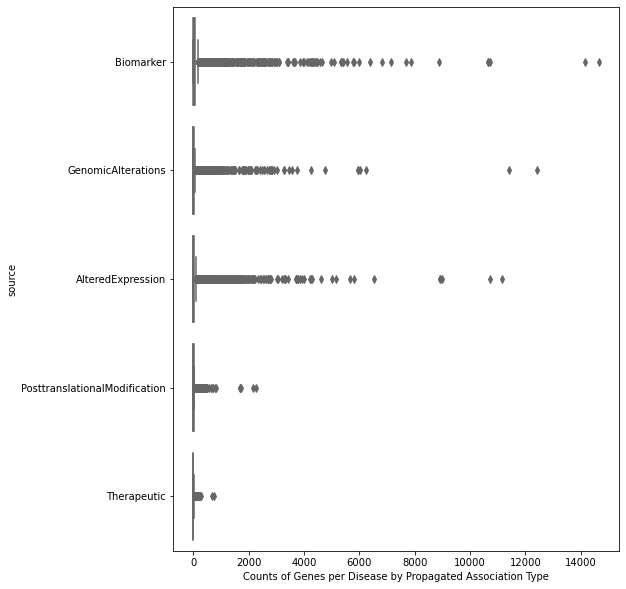

In [144]:
#Boxplot of Counts of Genes per Disease by Propagated Association Type
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Counts of Genes per Disease by Propagated Association Type',
                 data = SumDisease, palette="Set3", orient = 'h')

<AxesSubplot:xlabel='Log of Counts of Genes per Disease by Propagated Association Type', ylabel='source'>

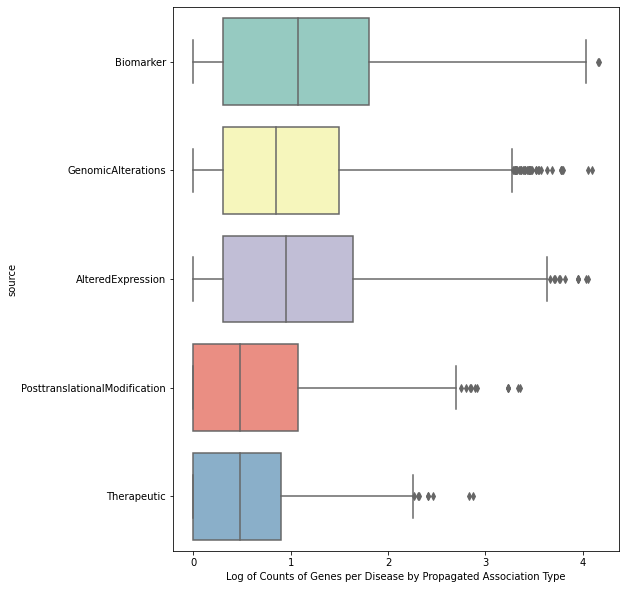

In [145]:
#Boxplot of Log of Counts of Genes per Disease by Propagated Association Type
fig, ax = plt.subplots(figsize = (8,10))
sns.boxplot(y = 'source', x = 'Log of Counts of Genes per Disease by Propagated Association Type',
                 data = SumDisease, palette="Set3", orient = 'h')

Text(0, 0.5, 'Frequency')

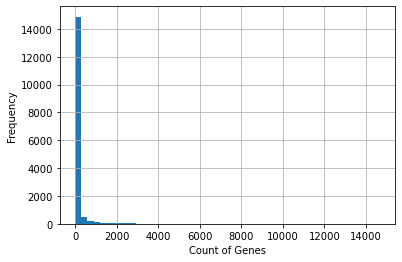

In [146]:
#Creating Histogram of Frequency of Gene Set Sizes for Propagated All Biomarker (partly Filtered) Dataset:
SumDisease['Counts of Genes per Disease by Propagated Association Type'].hist(bins=50)
plt.xlabel("Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

Text(0, 0.5, 'Frequency')

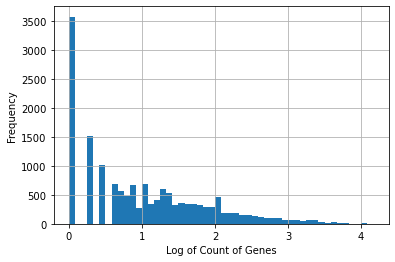

In [147]:
#Log Version of Histogram above:
SumDisease['Log of Counts of Genes per Disease by Propagated Association Type'].hist(bins=50)
plt.xlabel("Log of Count of Genes", fontsize=10)
plt.ylabel("Frequency",fontsize=10)

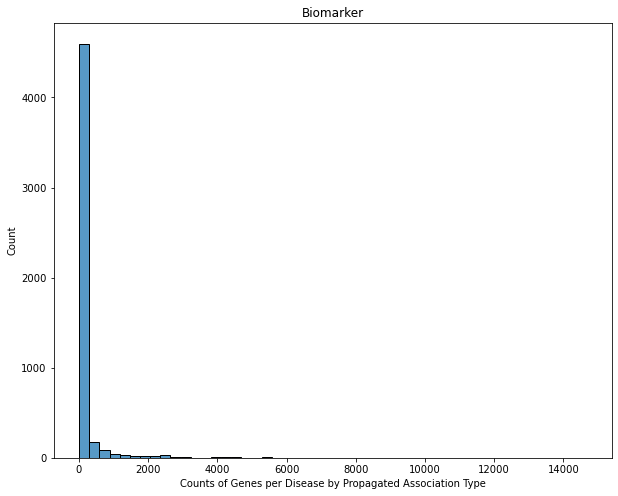

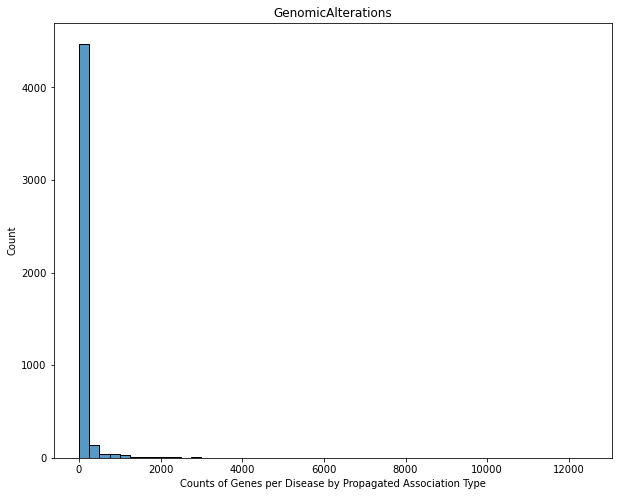

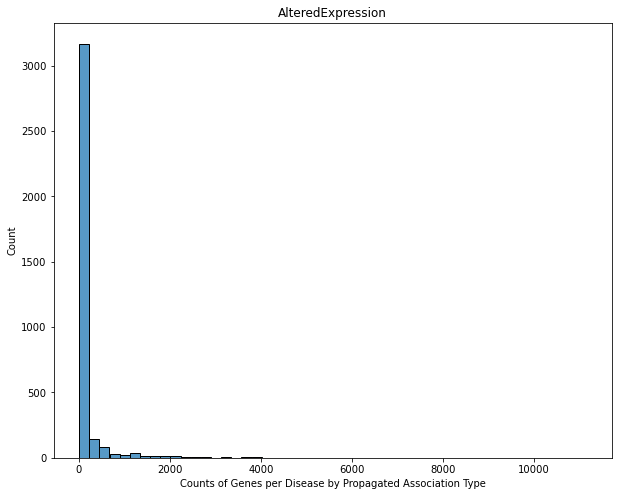

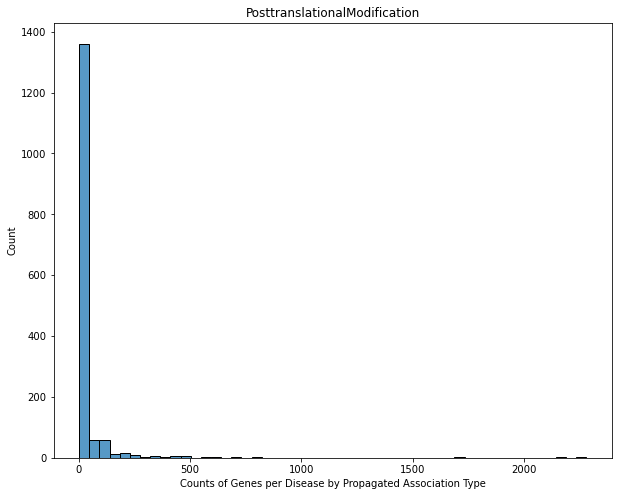

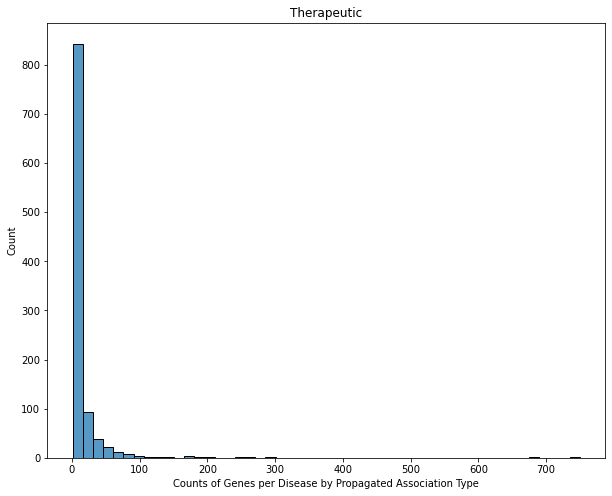

In [148]:
#Histograms broken down by association type:
for i, source in enumerate(SumDisease.source.unique(), 1):
    data = SumDisease[SumDisease.source == source]
    fig, ax = plt.subplots(figsize = (10,8))
    sns.histplot(data['Counts of Genes per Disease by Propagated Association Type'], bins=50)
    plt.title(source)

In [149]:
#Finding out all the disease terms that have 10+ genes (after propagation) from 3 different association types:

#Grouping by Propagated Association Type and only keeping gene-disease pairs with 3 or more association types
propagatedafter = propagated.groupby(by = ['DOID', 'diseaseName'])['source'].apply(lambda x: set(x))
propagatedafter = propagatedafter.reset_index()

propagatedafter2 = propagatedafter[propagatedafter['source'].map(lambda d: len(d)) >= 3]
propagatedafter2

,DOID,diseaseName,source
0,DOID:0001816,angiosarcoma,"{AlteredExpression, GenomicAlterations, Biomar..."
1,DOID:0002116,pterygium,"{AlteredExpression, Biomarker, Posttranslation..."
2,DOID:0014667,disease of metabolism,"{AlteredExpression, Biomarker, Posttranslation..."
3,DOID:0040084,Streptococcus pneumonia,"{AlteredExpression, GenomicAlterations, Biomar..."
4,DOID:0040086,Polyomavirus-associated Nephropathy,"{AlteredExpression, GenomicAlterations, Biomar..."
...,...,...,...
5290,DOID:9977,hallucinogen dependence,"{PosttranslationalModification, AlteredExpress..."
5291,DOID:998,eosinophilia-myalgia syndrome,"{AlteredExpression, GenomicAlterations, Biomar..."
5293,DOID:9988,tertiary neurosyphilis,"{AlteredExpression, GenomicAlterations, Biomar..."
5294,DOID:999,hypereosinophilic syndrome,"{AlteredExpression, Therapeutic, GenomicAltera..."


In [150]:
#Splitting the sources back up
propagatedafter3 = pd.DataFrame([(c, tup.DOID, tup.diseaseName) for tup in propagatedafter2.itertuples() for c in tup.source])
propagatedafter3 = propagatedafter3.rename(columns= {0: 'source', 1: 'DOID', 2: 'diseaseName'})
propagatedafter3

,source,DOID,diseaseName
0,AlteredExpression,DOID:0001816,angiosarcoma
1,GenomicAlterations,DOID:0001816,angiosarcoma
2,Biomarker,DOID:0001816,angiosarcoma
3,AlteredExpression,DOID:0002116,pterygium
4,Biomarker,DOID:0002116,pterygium
...,...,...,...
12724,Biomarker,DOID:999,hypereosinophilic syndrome
12725,PosttranslationalModification,DOID:9993,hypoglycemia
12726,AlteredExpression,DOID:9993,hypoglycemia
12727,GenomicAlterations,DOID:9993,hypoglycemia


In [151]:
#Adding the gene sets back into the table
propagatedafter4 = propagatedafter3.merge(propagated)
propagatedafter4

,source,DOID,diseaseName,geneSet
0,AlteredExpression,DOID:0001816,angiosarcoma,"{1553, 4151, 25069, 3215, 5139}"
1,GenomicAlterations,DOID:0001816,angiosarcoma,"{13399, 2808, 4138, 5241, 2390, 778, 26130, 64..."
2,Biomarker,DOID:0001816,angiosarcoma,"{8534, 3799, 2808, 5241, 2390}"
3,AlteredExpression,DOID:0002116,pterygium,"{6149, 1776, 2465, 5335, 1658, 10503, 25069, 1..."
4,Biomarker,DOID:0002116,pterygium,"{11167, 10503, 2708, 4270, 3800, 1530, 7651, 5..."
...,...,...,...,...
12724,Biomarker,DOID:999,hypereosinophilic syndrome,"{2571, 2604, 4584, 2268, 3289, 12507, 2593, 37..."
12725,PosttranslationalModification,DOID:9993,hypoglycemia,{4032}
12726,AlteredExpression,DOID:9993,hypoglycemia,"{133, 1658, 1793, 2524, 11698, 794, 109, 2056,..."
12727,GenomicAlterations,DOID:9993,hypoglycemia,"{5751, 10886, 4111, 3800, 2096, 2524, 462, 193..."


In [152]:
#To find the number of unique genes after propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in propagatedafter4.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})

In [153]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0001816,"{8534, 13399, 3799, 1553, 5241, 2390, 778, 250..."
1,DOID:0002116,"{6149, 1776, 2465, 2574, 11167, 5335, 1658, 10..."
2,DOID:0014667,"{17216, 4760, 1910, 3890, 8963, 9160, 6660, 82..."
3,DOID:0040084,"{4134, 9698, 2630, 3214, 3816, 2876, 1459, 250..."
4,DOID:0040086,"{2630, 1461, 10325, 1430, 2282, 144, 724, 8727..."
...,...,...
3397,DOID:9977,"{3978, 19565, 706, 20737, 2449, 2595, 11698, 9..."
3398,DOID:998,"{632, 5141, 1153, 2268, 15172, 1160, 942, 1735..."
3399,DOID:9988,"{5193, 4829, 4568, 1797, 1063, 8769, 2595, 184..."
3400,DOID:999,"{2571, 2604, 3289, 12507, 3694, 7684, 3376, 63..."


In [154]:
#Adding numgenes_prop into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist

In [155]:
propagatedafter5 = df.copy()
propagatedafter5 = propagatedafter5.reset_index()
#Only keeping the disease terms that have 10+ TOTAL genes (after propagation)
propagatedafter5 = propagatedafter5[propagatedafter5['numgenes_prop'].map(lambda d: d) >= 10]
propagatedafter5

,index,DOID,geneSet,numgenes_prop
0,0,DOID:0001816,"{8534, 13399, 3799, 1553, 5241, 2390, 778, 250...",16
1,1,DOID:0002116,"{6149, 1776, 2465, 2574, 11167, 5335, 1658, 10...",216
2,2,DOID:0014667,"{17216, 4760, 1910, 3890, 8963, 9160, 6660, 82...",5944
3,3,DOID:0040084,"{4134, 9698, 2630, 3214, 3816, 2876, 1459, 250...",100
4,4,DOID:0040086,"{2630, 1461, 10325, 1430, 2282, 144, 724, 8727...",12
...,...,...,...,...
3397,3397,DOID:9977,"{3978, 19565, 706, 20737, 2449, 2595, 11698, 9...",157
3398,3398,DOID:998,"{632, 5141, 1153, 2268, 15172, 1160, 942, 1735...",10
3399,3399,DOID:9988,"{5193, 4829, 4568, 1797, 1063, 8769, 2595, 184...",15
3400,3400,DOID:999,"{2571, 2604, 3289, 12507, 3694, 7684, 3376, 63...",105


In [156]:
#Finding out all the disease terms that have 5+ direct gene annotations (without propagation):
#Note: Our dataset before propagation is called desired12

#To find the number of unique genes before propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in desired12.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneNID']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneNID']})

In [157]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0002116,"{1527, 4613, 6149, 1034, 4106, 2572, 2574, 261..."
1,DOID:0014667,"{18432, 18433, 2052, 18436, 16390, 6, 2058, 20..."
2,DOID:0040084,"{14595, 3845, 2570, 1034, 1037, 782, 5134, 528..."
3,DOID:0040086,"{2176, 2630, 4934, 2282, 144, 4178, 724, 1461,..."
4,DOID:0040091,"{2433, 2946, 6916, 775, 7687, 13576, 3212, 666..."
...,...,...
4850,DOID:9986,"{737, 3893}"
4851,DOID:9988,"{8769, 19393, 18501, 2630, 5193, 5194, 2575, 2..."
4852,DOID:999,"{8193, 9224, 1034, 1037, 2066, 19, 20, 5141, 6..."
4853,DOID:9993,"{2048, 5122, 1027, 1028, 3078, 2056, 1032, 205..."


In [158]:
#Adding numgenes_dir into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist

In [159]:
desired12before = df.copy()
desired12before = desired12before.reset_index()
#Only keeping the disease terms that have 5+ TOTAL direct gene annotations (without propagation)
desired12before = desired12before[desired12before['numgenes_dir'].map(lambda d: d) >= 5]
desired12before

,index,DOID,geneId,numgenes_dir
0,0,DOID:0002116,"{1527, 4613, 6149, 1034, 4106, 2572, 2574, 261...",216
1,1,DOID:0014667,"{18432, 18433, 2052, 18436, 16390, 6, 2058, 20...",945
2,2,DOID:0040084,"{14595, 3845, 2570, 1034, 1037, 782, 5134, 528...",100
3,3,DOID:0040086,"{2176, 2630, 4934, 2282, 144, 4178, 724, 1461,...",12
4,4,DOID:0040091,"{2433, 2946, 6916, 775, 7687, 13576, 3212, 666...",49
...,...,...,...,...
4848,4848,DOID:9976,"{770, 1282, 1029, 6, 1030, 1031, 12, 2061, 271...",100
4849,4849,DOID:998,"{1153, 2274, 15172, 1735, 1160, 942, 2516, 514...",10
4851,4851,DOID:9988,"{8769, 19393, 18501, 2630, 5193, 5194, 2575, 2...",21
4852,4852,DOID:999,"{8193, 9224, 1034, 1037, 2066, 19, 20, 5141, 6...",328


In [160]:
#Merging datasets from two filters:
propagatedafter5 = propagatedafter5.drop(columns = 'index')
desired12before = desired12before.drop(columns = 'index')
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0002116,216,216
1,DOID:0014667,5944,945
2,DOID:0040084,100,100
3,DOID:0040086,12,12
4,DOID:0040091,49,49
...,...,...,...
2561,DOID:9976,100,100
2562,DOID:998,10,10
2563,DOID:9988,15,21
2564,DOID:999,105,328


In [161]:
#Intersecting this dataset with the propagated DISEASE dataset to get back the genesets (of propagation, like was requested prior), association type, and disease name
mergedNew = mergedNew.merge(propagated)
mergedNew = mergedNew.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew = mergedNew[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0002116,pterygium,AlteredExpression,216,216,"{6149, 1776, 2465, 5335, 1658, 10503, 25069, 1..."
1,DOID:0002116,pterygium,Biomarker,216,216,"{11167, 10503, 2708, 4270, 3800, 1530, 7651, 5..."
2,DOID:0002116,pterygium,GenomicAlterations,216,216,"{8560, 2574, 1110, 10503, 4411, 2126, 5420, 54..."
3,DOID:0002116,pterygium,PosttranslationalModification,216,216,"{5241, 778, 1317, 26130, 750}"
4,DOID:0002116,pterygium,Therapeutic,216,216,{2501}
...,...,...,...,...,...,...
9780,DOID:999,hypereosinophilic syndrome,Therapeutic,105,328,"{1872, 4256}"
9781,DOID:9993,hypoglycemia,AlteredExpression,420,420,"{133, 1658, 1793, 2524, 11698, 794, 109, 2056,..."
9782,DOID:9993,hypoglycemia,Biomarker,420,420,"{3437, 10334, 2171, 1933, 3166, 13684, 3932, 1..."
9783,DOID:9993,hypoglycemia,GenomicAlterations,420,420,"{5751, 10886, 4111, 3800, 2096, 2524, 462, 193..."


In [162]:
#Creating columns for counts of genes for each association type
mergedNew['numgenes_AlteredExpression'] = np.NaN
mergedNew['numgenes_Biomarker'] = np.NaN
mergedNew['numgenes_GenomicAlterations'] = np.NaN
mergedNew['numgenes_PosttranslationalModification'] = np.NaN
mergedNew['numgenes_Therapeutic'] = np.NaN

In [163]:
#Finding count of genes for Altered Expression for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'AlteredExpression'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_AlteredExpression'] = templist

In [164]:
#Finding count of genes for Biomarker for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'Biomarker'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_Biomarker'] = templist

In [165]:
#Finding count of genes for Genomic Alterations for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'GenomicAlterations'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_GenomicAlterations'] = templist

In [166]:
#Finding count of genes for Posttranslational Modification for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'PosttranslationalModification'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_PosttranslationalModification'] = templist

In [167]:
#Finding count of genes for Therapeutic for each disease
templist = []
for index, row, in mergedNew.iterrows():
    if (row['source'] == 'Therapeutic'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew['numgenes_Therapeutic'] = templist

In [168]:
#Grouping together rows with the same DOID, name, numgenes_dir, and numgenes_prop
ArjunData = mergedNew.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData = ArjunData.reset_index()
#Sorting data so that the highest number of unique genes is on the top
ArjunData = ArjunData.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData = ArjunData[['dis_doid', 'dis_name','numgenes_AlteredExpression', 'numgenes_Biomarker', 'numgenes_GenomicAlterations',
       'numgenes_PosttranslationalModification', 'numgenes_Therapeutic', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_AlteredExpression,numgenes_Biomarker,numgenes_GenomicAlterations,numgenes_PosttranslationalModification,numgenes_Therapeutic,numgenes_dir,numgenes_prop
2387,DOID:863,nervous system disease,5174,8872,6231,636,258,977,11042
2305,DOID:77,gastrointestinal system disease,5673,7864,4239,780,176,150,10208
1708,DOID:331,central nervous system disease,4294,7148,4777,494,204,319,9248
2066,DOID:5295,intestinal disease,3862,5549,2855,454,60,209,7627
1390,DOID:17,musculoskeletal system disease,3751,5763,3281,257,54,38,7593
...,...,...,...,...,...,...,...,...,...
219,DOID:0060652,familial erythrocytosis 1,1,2,8,0,0,31,10
1478,DOID:2211,factor XIII deficiency,1,7,3,1,0,10,10
1266,DOID:13884,sick sinus syndrome,9,1,1,0,1,52,10
1481,DOID:2217,Bernard-Soulier syndrome,8,3,3,0,0,46,10


In [169]:
#Getting a count of the number of association types have 10+ genes under them. This count is appended to the dataset
templist = []
for index, row, in ArjunData.iterrows():
    tempcount = 0
    if (row['numgenes_AlteredExpression'] >= 10):
        tempcount += 1
    if (row['numgenes_Biomarker'] >= 10):
        tempcount += 1
    if (row['numgenes_GenomicAlterations'] >= 10):
        tempcount += 1
    if (row['numgenes_PosttranslationalModification'] >= 10):
        tempcount += 1
    if (row['numgenes_Therapeutic'] >= 10):
        tempcount += 1
    else:
        tempcount += 0
    templist.append(tempcount)
ArjunData['tempcounts'] = templist

In [170]:
#Filtering out diseases that did not have at least 10 genes after propagation from EACH ASSOCIATION TYPE for at least three ASSOCIATION TYPES
ArjunData2 = ArjunData[ArjunData['tempcounts'].map(lambda d: d) >= 3]
ArjunData2 = ArjunData2.drop(columns = 'tempcounts')
ArjunData2

,dis_doid,dis_name,numgenes_AlteredExpression,numgenes_Biomarker,numgenes_GenomicAlterations,numgenes_PosttranslationalModification,numgenes_Therapeutic,numgenes_dir,numgenes_prop
2387,DOID:863,nervous system disease,5174,8872,6231,636,258,977,11042
2305,DOID:77,gastrointestinal system disease,5673,7864,4239,780,176,150,10208
1708,DOID:331,central nervous system disease,4294,7148,4777,494,204,319,9248
2066,DOID:5295,intestinal disease,3862,5549,2855,454,60,209,7627
1390,DOID:17,musculoskeletal system disease,3751,5763,3281,257,54,38,7593
...,...,...,...,...,...,...,...,...,...
1336,DOID:14695,galactokinase deficiency,10,19,10,0,0,32,29
2549,DOID:9870,galactosemia,10,19,10,0,0,29,29
1730,DOID:3369,Ewing sarcoma,11,10,11,1,0,649,28
1151,DOID:12801,mucopolysaccharidosis III,11,18,11,0,0,39,25


In [171]:
ArjunData2.to_csv('OutputFiles/DesiredDataArjunAssociations.tsv', index = False, sep = "\t")

## Making the All Data File:

In [172]:
#Taking the All Biomarker Recategorized Propagated Dataset with gene sets and dropping the disease name column
resultDOIDshort = resultDOID.drop(columns = 'diseaseName')
#Creating a dictionary for each association type. Note: the name is a bit misleading, sorry
dict_of_sources = dict(iter(resultDOIDshort.groupby('propagatedAssociationType')))

In [173]:
#Creaing a separate dictionary for each association type
AE_dict = dict(zip(dict_of_sources['AlteredExpression'].DOID, dict_of_sources['AlteredExpression'].geneNID))
BM_human_dict = dict(zip(dict_of_sources['Biomarker'].DOID, dict_of_sources['Biomarker'].geneNID))
GA_dict = dict(zip(dict_of_sources['GenomicAlterations'].DOID, dict_of_sources['GenomicAlterations'].geneNID))
PTM_dict = dict(zip(dict_of_sources['PosttranslationalModification'].DOID, dict_of_sources['PosttranslationalModification'].geneNID))
T_dict = dict(zip(dict_of_sources['Therapeutic'].DOID, dict_of_sources['Therapeutic'].geneNID))

In [174]:
#Creating a propagated dictionary for each association type
AE_prop = disease_ontology.propagate(AE_dict)
BM_prop = disease_ontology.propagate(BM_human_dict)
GA_prop = disease_ontology.propagate(GA_dict)
PTM_prop = disease_ontology.propagate(PTM_dict)
T_prop = disease_ontology.propagate(T_dict)

In [175]:
#Turning each dictionary into a dataframe
AE = pd.DataFrame([k for k in AE_prop.items()], columns=['DOID', 'geneSet'])
BM = pd.DataFrame([k for k in BM_prop.items()], columns=['DOID', 'geneSet'])
GA = pd.DataFrame([k for k in GA_prop.items()], columns=['DOID', 'geneSet'])
PTM = pd.DataFrame([k for k in PTM_prop.items()], columns=['DOID', 'geneSet'])
T = pd.DataFrame([k for k in T_prop.items()], columns=['DOID', 'geneSet'])

In [179]:
#Creating a column in each association type dataset for the name of the dataset (so that this info will be available once the datasets are apended back together)
#Note, I call them sources here, but they are really association types. It won't matter in the end because I will be changing the name of the column later
AE['source'] = 'AlteredExpression'
BM['source'] = 'Biomarker'
GA['source'] = 'GenomicAlterations'
PTM['source'] = 'PosttranslationalModification'
T['source'] = 'Therapeutic'
#Appending the datasets back together
propagated = AE.append(BM).append(GA).append(PTM).append(T)

In [180]:
#Adding the disease name back into the dataset
templist = []
for index, row, in propagated.iterrows():
    if (row['DOID'] in disease_ontology.nodes):
        templist.append(disease_ontology.nodes[row['DOID']]["name"])
    else:
        templist.append("error")
propagated['diseaseName'] = templist
propagated

,DOID,geneSet,source,diseaseName
0,DOID:0001816,"{778, 3084, 780, 1553, 5139, 10260, 1567, 5158...",AlteredExpression,angiosarcoma
1,DOID:162,"{1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 1...",AlteredExpression,cancer
2,DOID:14566,"{1, 2, 4, 5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 1...",AlteredExpression,disease of cellular proliferation
3,DOID:4,"{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...",AlteredExpression,disease
4,DOID:1115,"{7, 8201, 8218, 38, 16425, 50, 54, 55, 8248, 1...",AlteredExpression,sarcoma
...,...,...,...,...
1140,DOID:9673,{7854},Therapeutic,ulcerative stomatitis
1141,DOID:9675,{5141},Therapeutic,pulmonary emphysema
1142,DOID:9778,{6000},Therapeutic,irritable bowel syndrome
1143,DOID:9854,{13623},Therapeutic,lingual-facial-buccal dyskinesia


In [181]:
#Finding numgenes_prop:

#To find the number of unique genes after propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in propagated.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneSet']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneSet']})

In [182]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneSet'])
df

,DOID,geneSet
0,DOID:0001816,"{26117, 11784, 1035, 5132, 6156, 3084, 1553, 2..."
1,DOID:162,"{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1..."
2,DOID:14566,"{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1..."
3,DOID:4,"{1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1..."
4,DOID:1115,"{7, 8201, 11, 13, 19, 21, 8218, 38, 8231, 1642..."
...,...,...
7030,DOID:10290,"{1334, 3558}"
7031,DOID:2533,{1066}
7032,DOID:4406,"{778, 26130, 750}"
7033,DOID:4860,"{778, 26130}"


In [183]:
#Adding numgenes_prop into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneSet']))
df['numgenes_prop'] = templist

In [184]:
propagatedafter5 = df.copy()
propagatedafter5

,DOID,geneSet,numgenes_prop
0,DOID:0001816,"{26117, 11784, 1035, 5132, 6156, 3084, 1553, 2...",169
1,DOID:162,"{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...",14408
2,DOID:14566,"{1, 2, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 1...",14501
3,DOID:4,"{1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1...",18495
4,DOID:1115,"{7, 8201, 11, 13, 19, 21, 8218, 38, 8231, 1642...",2748
...,...,...,...
7030,DOID:10290,"{1334, 3558}",2
7031,DOID:2533,{1066},1
7032,DOID:4406,"{778, 26130, 750}",3
7033,DOID:4860,"{778, 26130}",2


In [185]:
#Finding numgenes_dir:
#Note: Our dataset before propagation is called resultDOID

#To find the number of unique genes before propagation, I create a dictionary (key: DOID, label: geneset)
#Making it into a dictionary is an easy way to remove duplicate genes
tempdict = {}
for index, row, in resultDOID.iterrows():
    if (row['DOID'] in tempdict):
        tempvaldict = tempdict.get(row['DOID'])
        tempvaldf = row['geneNID']
        tempvalmerge = tempvaldf.union(tempvaldict)
        tempdict.update({row['DOID']: tempvalmerge})
    else:
        tempdict.update({row['DOID']: row['geneNID']})

In [186]:
#Turning the dictionary back into a dataset
df = pd.DataFrame([k for k in tempdict.items()], columns=['DOID', 'geneId'])
df

,DOID,geneId
0,DOID:0001816,"{26117, 11784, 1035, 5132, 6156, 3084, 1553, 3..."
1,DOID:0002116,"{1527, 4613, 6149, 1034, 4106, 2572, 2574, 261..."
2,DOID:0014667,"{18432, 18433, 2052, 18436, 16390, 6, 2058, 20..."
3,DOID:0040084,"{14595, 3845, 2570, 1034, 1037, 782, 5134, 528..."
4,DOID:0040085,"{2, 8205, 17, 22, 8220, 4127, 32, 8227, 36, 41..."
...,...,...
6634,DOID:9986,"{737, 3893}"
6635,DOID:9988,"{8769, 19393, 18501, 2630, 5193, 5194, 2575, 2..."
6636,DOID:999,"{8193, 9224, 1034, 1037, 2066, 19, 20, 5141, 6..."
6637,DOID:9993,"{2048, 5122, 1027, 1028, 3078, 2056, 1032, 205..."


In [187]:
#Adding numgenes_dir into the dataset
templist = []
for index, row, in df.iterrows():
    templist.append(len(row['geneId']))
df['numgenes_dir'] = templist

In [188]:
desired12before = df.copy()
desired12before

,DOID,geneId,numgenes_dir
0,DOID:0001816,"{26117, 11784, 1035, 5132, 6156, 3084, 1553, 3...",163
1,DOID:0002116,"{1527, 4613, 6149, 1034, 4106, 2572, 2574, 261...",216
2,DOID:0014667,"{18432, 18433, 2052, 18436, 16390, 6, 2058, 20...",945
3,DOID:0040084,"{14595, 3845, 2570, 1034, 1037, 782, 5134, 528...",100
4,DOID:0040085,"{2, 8205, 17, 22, 8220, 4127, 32, 8227, 36, 41...",1453
...,...,...,...
6634,DOID:9986,"{737, 3893}",2
6635,DOID:9988,"{8769, 19393, 18501, 2630, 5193, 5194, 2575, 2...",21
6636,DOID:999,"{8193, 9224, 1034, 1037, 2066, 19, 20, 5141, 6...",328
6637,DOID:9993,"{2048, 5122, 1027, 1028, 3078, 2056, 1032, 205...",420


In [189]:
#Intersecting Datasets to have one with number of genes propagated and direct:
mergedNew = propagatedafter5.merge(desired12before, how = 'inner')
mergedNew = mergedNew.drop(columns = ['geneSet', 'geneId'])
mergedNew

,DOID,numgenes_prop,numgenes_dir
0,DOID:0001816,169,163
1,DOID:162,14408,11480
2,DOID:1115,2748,706
3,DOID:0002116,216,216
4,DOID:10124,971,47
...,...,...,...
6634,DOID:10290,2,2
6635,DOID:2533,1,1
6636,DOID:4406,3,3
6637,DOID:4860,2,2


In [195]:
#Intersecting this dataset with the propagated DISEASE dataset to get back the genesets (of propagation, like was requested prior), association type, and disease name
test = mergedNew.merge(propagated)
test

,DOID,numgenes_prop,numgenes_dir,geneSet,source,diseaseName
0,DOID:0001816,169,163,"{778, 3084, 780, 1553, 5139, 10260, 1567, 5158...",AlteredExpression,angiosarcoma
1,DOID:0001816,169,163,"{3840, 771, 11784, 778, 6156, 3090, 26130, 105...",Biomarker,angiosarcoma
2,DOID:0001816,169,163,"{3840, 26117, 778, 1035, 5132, 1935, 26130, 64...",GenomicAlterations,angiosarcoma
3,DOID:0001816,169,163,"{229, 5241, 13997}",PosttranslationalModification,angiosarcoma
4,DOID:0001816,169,163,{1066},Therapeutic,angiosarcoma
...,...,...,...,...,...,...
19160,DOID:10290,2,2,"{1334, 3558}",PosttranslationalModification,prostate lymphoma
19161,DOID:2533,1,1,{1066},PosttranslationalModification,splenic infarction
19162,DOID:4406,3,3,"{778, 26130, 750}",PosttranslationalModification,spongiotic dermatitis
19163,DOID:4860,2,2,"{778, 26130}",PosttranslationalModification,brain stem astrocytic neoplasm


In [196]:
mergedNew2 = test.rename(columns = {'DOID': 'dis_doid', 'diseaseName': 'dis_name'})
mergedNew2 = mergedNew2[['dis_doid', 'dis_name', 'source', 'numgenes_prop', 'numgenes_dir', 'geneSet']]
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet
0,DOID:0001816,angiosarcoma,AlteredExpression,169,163,"{778, 3084, 780, 1553, 5139, 10260, 1567, 5158..."
1,DOID:0001816,angiosarcoma,Biomarker,169,163,"{3840, 771, 11784, 778, 6156, 3090, 26130, 105..."
2,DOID:0001816,angiosarcoma,GenomicAlterations,169,163,"{3840, 26117, 778, 1035, 5132, 1935, 26130, 64..."
3,DOID:0001816,angiosarcoma,PosttranslationalModification,169,163,"{229, 5241, 13997}"
4,DOID:0001816,angiosarcoma,Therapeutic,169,163,{1066}
...,...,...,...,...,...,...
19160,DOID:10290,prostate lymphoma,PosttranslationalModification,2,2,"{1334, 3558}"
19161,DOID:2533,splenic infarction,PosttranslationalModification,1,1,{1066}
19162,DOID:4406,spongiotic dermatitis,PosttranslationalModification,3,3,"{778, 26130, 750}"
19163,DOID:4860,brain stem astrocytic neoplasm,PosttranslationalModification,2,2,"{778, 26130}"


In [197]:
#Creating columns for counts of genes for each association type
mergedNew2['numgenes_AlteredExpression'] = np.NaN
mergedNew2['numgenes_Biomarker'] = np.NaN
mergedNew2['numgenes_GenomicAlterations'] = np.NaN
mergedNew2['numgenes_PosttranslationalModification'] = np.NaN
mergedNew2['numgenes_Therapeutic'] = np.NaN
mergedNew2

,dis_doid,dis_name,source,numgenes_prop,numgenes_dir,geneSet,numgenes_AlteredExpression,numgenes_Biomarker,numgenes_GenomicAlterations,numgenes_PosttranslationalModification,numgenes_Therapeutic
0,DOID:0001816,angiosarcoma,AlteredExpression,169,163,"{778, 3084, 780, 1553, 5139, 10260, 1567, 5158...",NaN,NaN,NaN,NaN,NaN
1,DOID:0001816,angiosarcoma,Biomarker,169,163,"{3840, 771, 11784, 778, 6156, 3090, 26130, 105...",NaN,NaN,NaN,NaN,NaN
2,DOID:0001816,angiosarcoma,GenomicAlterations,169,163,"{3840, 26117, 778, 1035, 5132, 1935, 26130, 64...",NaN,NaN,NaN,NaN,NaN
3,DOID:0001816,angiosarcoma,PosttranslationalModification,169,163,"{229, 5241, 13997}",NaN,NaN,NaN,NaN,NaN
4,DOID:0001816,angiosarcoma,Therapeutic,169,163,{1066},NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
19160,DOID:10290,prostate lymphoma,PosttranslationalModification,2,2,"{1334, 3558}",NaN,NaN,NaN,NaN,NaN
19161,DOID:2533,splenic infarction,PosttranslationalModification,1,1,{1066},NaN,NaN,NaN,NaN,NaN
19162,DOID:4406,spongiotic dermatitis,PosttranslationalModification,3,3,"{778, 26130, 750}",NaN,NaN,NaN,NaN,NaN
19163,DOID:4860,brain stem astrocytic neoplasm,PosttranslationalModification,2,2,"{778, 26130}",NaN,NaN,NaN,NaN,NaN


In [198]:
#Finding count of genes for Altered Expression for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'AlteredExpression'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_AlteredExpression'] = templist

In [199]:
#Finding count of genes for Biomarker for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'Biomarker'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_Biomarker'] = templist

In [200]:
#Finding count of genes for Genomic Alterations for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'GenomicAlterations'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_GenomicAlterations'] = templist

In [201]:
#Finding count of genes for Posttranslational Modification for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'PosttranslationalModification'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_PosttranslationalModification'] = templist

In [202]:
#Finding count of genes for Therapeutic for each disease
templist = []
for index, row, in mergedNew2.iterrows():
    if (row['source'] == 'Therapeutic'):
        templist.append(len(row['geneSet']))
    else:
        templist.append(0)
mergedNew2['numgenes_Therapeutic'] = templist

In [203]:
#Grouping together rows with the same DOID, name, numgenes_dir, and numgenes_prop
ArjunData = mergedNew2.groupby(['dis_doid', 'dis_name', 'numgenes_dir', 'numgenes_prop']).sum()
ArjunData = ArjunData.reset_index()
#Sorting data so that the highest number of unique genes is on the top
ArjunData = ArjunData.sort_values(by = 'numgenes_prop', ascending = False)
ArjunData = ArjunData[['dis_doid', 'dis_name','numgenes_AlteredExpression', 'numgenes_Biomarker', 'numgenes_GenomicAlterations',
       'numgenes_PosttranslationalModification', 'numgenes_Therapeutic', 'numgenes_dir', 'numgenes_prop']]
ArjunData

,dis_doid,dis_name,numgenes_AlteredExpression,numgenes_Biomarker,numgenes_GenomicAlterations,numgenes_PosttranslationalModification,numgenes_Therapeutic,numgenes_dir,numgenes_prop
4354,DOID:162,cancer,9908,12125,6890,1998,215,11480,14408
6303,DOID:863,nervous system disease,5174,8872,6231,636,258,977,11042
4842,DOID:305,carcinoma,6767,8033,3679,951,58,2544,10230
6150,DOID:77,gastrointestinal system disease,5673,7864,4239,780,176,150,10208
4820,DOID:2994,germ cell cancer,5386,7697,2888,637,26,308,9270
...,...,...,...,...,...,...,...,...,...
5663,DOID:5368,Wolffian duct adenocarcinoma,0,0,1,0,0,1,1
2510,DOID:0110675,congenital myasthenic syndrome 11,0,1,1,0,0,1,1
2511,DOID:0110676,congenital myasthenic syndrome 13,0,1,1,0,0,1,1
2515,DOID:0110680,congenital myasthenic syndrome 2C,0,1,0,0,0,1,1


In [204]:
ArjunData.to_csv('OutputFiles/DesiredDataArjunAssociationAllDisease.tsv', index = False, sep = "\t")